In [ ]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6

In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union, Callable


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from flwr.server.strategy import Strategy
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, Status, GetParametersRes, Parameters, GetParametersIns, MetricsAggregationFn,NDArrays,Scalar
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.server.strategy import FedAvg, FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.15.1 / PyTorch 2.6.0


In [2]:

BATCH_SIZE = 32

def load_datasets(partition_id, num_partitions: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=32)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32)
    return trainloader, valloader, testloader

In [3]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MoonNet(nn.Module):
    """Returns both the representation (penultimate layer output) and classification"""
    def __init__(self) -> None:
        super(MoonNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        representation = x.clone()
        classification = self.fc3(x)
        return representation, classification

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(),betas=(0.999,0.999))
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        
def proxima_train(net, trainloader, epochs: int, proximal_mu:float, global_params:List[torch.Tensor]):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)

            proximal_term = 0.0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(images), labels) + (proximal_mu / 2) * proximal_term


            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def train_moon(net,train_loader, global_net,previous_net, epochs, mu, temperature):
    """Training function for MOON."""
    print(f"Started training moon")
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    previous_net.eval()
    global_net.eval()

    cnt = 0
    cos = torch.nn.CosineSimilarity(dim=-1)

    for epoch in range(epochs):
        epoch_loss_collector = []
        epoch_loss1_collector = []
        epoch_loss2_collector = []
        for batch in train_loader:
            x, target = batch["img"], batch["label"]
            x, target = x.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()

            # pro1 is the representation by the current model (Line 14 of Algorithm 1)
            pro1, out = net(x)
            # pro2 is the representation by the global model (Line 15 of Algorithm 1)
            # pro3 is the representation by the previous model (Line 16 of Algorithm 1)
            with torch.no_grad():
                pro2, _ = global_net(x)
                pro3, _ = previous_net(x)

            # posi is the positive pair
            posi = cos(pro1, pro2)
            logits = posi.reshape(-1, 1)

            # nega is the negative pair
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1, 1)), dim=1)

            previous_net.to("cpu")
            logits /= temperature
            labels = torch.zeros(x.size(0)).to(DEVICE).long()

            # compute the model-contrastive loss (Line 17 of Algorithm 1)
            loss2 = mu * criterion(logits, labels)

            # compute the cross-entropy loss (Line 13 of Algorithm 1)
            loss1 = criterion(out, target)

            # compute the loss (Line 18 of Algorithm 1)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())
            epoch_loss1_collector.append(loss1.item())
            epoch_loss2_collector.append(loss2.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        epoch_loss1 = sum(epoch_loss1_collector) / len(epoch_loss1_collector)
        epoch_loss2 = sum(epoch_loss2_collector) / len(epoch_loss2_collector)
        print(
            "Epoch: %d Loss: %f Loss1: %f Loss2: %f"
            % (epoch, epoch_loss, epoch_loss1, epoch_loss2)
        )


def test_moon(net, testloader):
    """
    Evaluate the network on the entire test set.
    Same as the regular test, but using the MoonNet 
    (where the output is a tuple of (representation, classification) )
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            _, outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy




def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
        """Freeze specified layers of the model."""
        for idx, (name, param) in enumerate(model.named_parameters()):
            if idx == trainable_layers or trainable_layers == -1:
                param.requires_grad = True
            else:
                param.requires_grad = False

In [4]:

NETWORK_LEN = len(Net().state_dict().keys())
EPOCHS = 2
NUM_PARTITIONS = 3
NUM_OF_CYCLES  = 1
NUM_OF_FULL_UPDATES_BETWEEN_CYCLES = 5
NUM_OF_ROUNDS = (NUM_OF_CYCLES * NUM_OF_FULL_UPDATES_BETWEEN_CYCLES) + (NUM_OF_CYCLES * NETWORK_LEN *2)
print(f"Number of rounds: {NUM_OF_ROUNDS}")
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}


Number of rounds: 25


In [5]:
from flwr.common import NDArrays, Scalar

def get_evaluate_fn(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate

# Normal FedAvg

In [6]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_avg_result = {}
fed_avg_model_results = {}

class ModifiedFedAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_avg_model_results:
            expand_fed_avg_result= {**fed_avg_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_avg_result= {"global_loss": loss, "global_metrics": metrics}

        fed_avg_model_results[server_round] = expand_fed_avg_result

        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        

        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_size": total_size}
        else:
            expand_fed_avg_result= {"total_size": total_size}

        fed_avg_result[server_round] = expand_fed_avg_result


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_avg_result= {"total_loss": total_loss}

        fed_avg_result[server_round] = expand_fed_avg_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [7]:
class NormalFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}



def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return NormalFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [ ]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedAvg(
            evaluate_fn=evaluate_fn
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


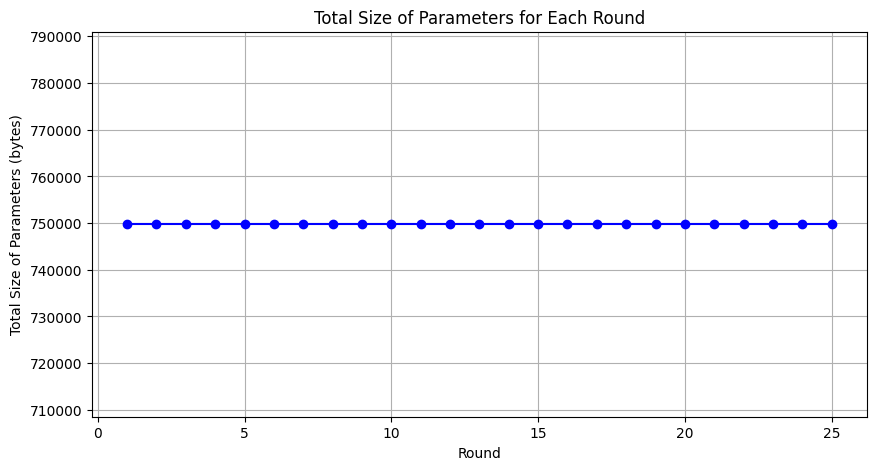

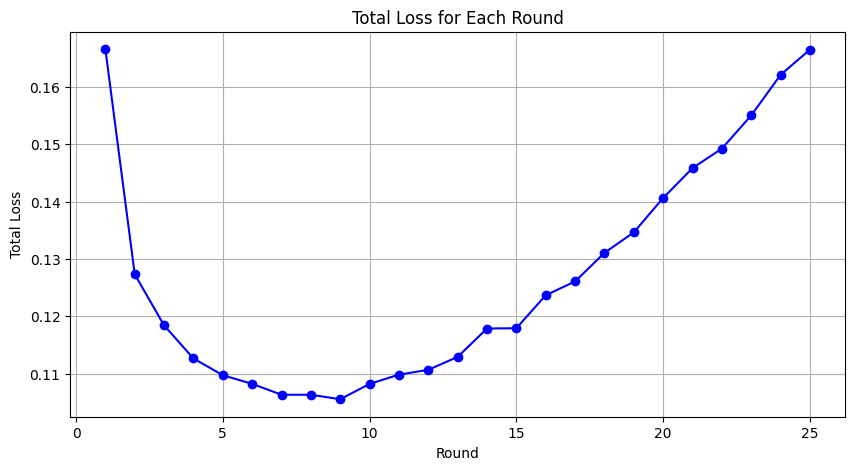

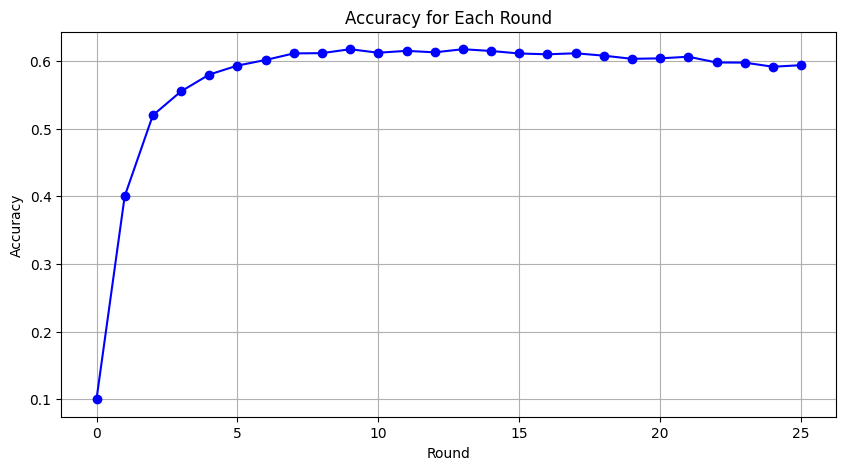

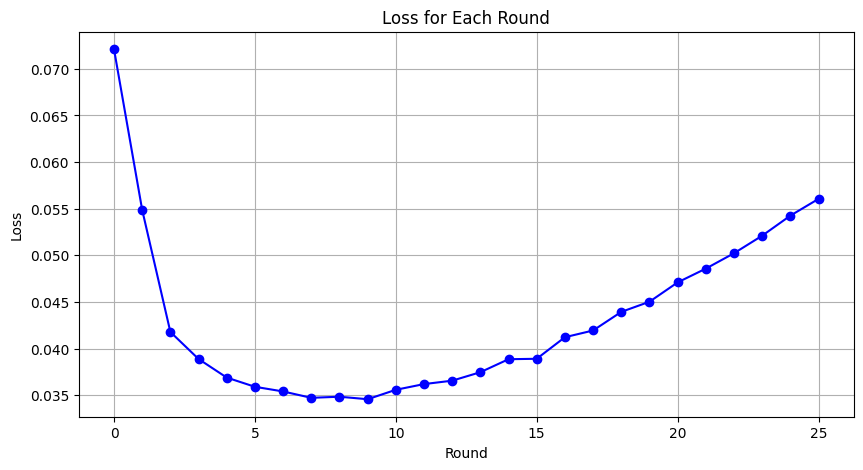

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fed_avg_rounds = list(fed_avg_result.keys())
fed_avg_sizes = [fed_avg_result[round]["total_size"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.grid(True)

fed_avg_losses = [fed_avg_result[round]["total_loss"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.grid(True)

fed_avg_model_rounds = list(fed_avg_model_results.keys())

fed_avg_accuracies = [fed_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.grid(True)

fed_avg_global_losses = [fed_avg_model_results[round]["global_loss"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.grid(True)

# FedAvgPart Experiments

In [11]:
from typing import Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

fed_part_avg_result = {}

fed_part_avg_model_results = {}


class FedPartAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace

        self.layer_update_strategy = layer_update_strategy  # 'sequential' or 'cyclic'
        self.current_layer = 0  # Track which layer to update
        self.number_of_layers = None
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        self.layer_training_sequence = self.generate_layer_training_sequence()
        self.number_of_layers = len(ndarrays)

        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_avg_model_results:  
            expand_fed_part_avg_model_results= {**fed_part_avg_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_avg_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_avg_model_results[server_round] = expand_fed_part_avg_model_results
        
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index]}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_size"] = total_size
        else:
            fed_part_avg_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_avg_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    

In [12]:
class FedAvgPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        freeze_layers(self.net, config["trainable_layers"])
        train(self.net, self.trainloader, epochs=EPOCHS)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedAvgPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [ ]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartAvg(
            evaluate_fn=evaluate_fn,
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07212925009727478, {'accuracy': 0.1001}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87289) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=87289) Epoch 1: train loss 0.06368256360292435, accuracy 0.25577557755775576
(ClientAppActor pid=87290) [Client 0] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=87289) [Client 2] get_parameters
(ClientAppActor pid=87289) Epoch 2: train loss 0.055297333747148514, accuracy 0.3496099609960996 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749784


INFO :      fit progress: (1, 0.05967725586891175, {'accuracy': 0.3094}, 22.11468524999873)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87289) [Client 2] evaluate, config: {}
(ClientAppActor pid=87290) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=87290) Epoch 2: train loss 0.05427784100174904, accuracy 0.3638340958523963 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87288) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=87290) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=87288) Epoch 1: train loss 0.05289163440465927, accuracy 0.3714092852321308
(ClientAppActor pid=87289) [Client 2] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=87290) Epoch 1: train loss 0.053172025829553604, accuracy 0.3660841521038026


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=87290) [Client 1] get_parameters
(ClientAppActor pid=87290) Epoch 2: train loss 0.04869585484266281, accuracy 0.4279606990174754 [repeated 2x across cluster]
total size: 749784


INFO :      fit progress: (2, 0.04778525449037552, {'accuracy': 0.4436}, 41.387992542000575)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87289) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87289) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=87289) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=87289) Epoch 2: train loss 0.04952521622180939, accuracy 0.417041704170417 [repeated 2x across cluster]
(ClientAppActor pid=87288) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=87288) [Client 0] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=87289) Epoch 1: train loss 0.04729476198554039, accuracy 0.4498949894989499
(ClientAppActor pid=87290) Epoch 1: train loss 0.04767583683133125, accuracy 0.43838595964899124
(ClientAppActor pid=87289) [Client 2] get_parameters
(ClientAppActor pid=87289) Epoch 2: train loss 0.04417239874601364, accuracy 0.48267326732673266 [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749784


INFO :      fit progress: (3, 0.04379869381785393, {'accuracy': 0.4901}, 61.15254741700119)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87289) [Client 2] evaluate, config: {}
(ClientAppActor pid=87288) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=87288) Epoch 2: train loss 0.04540057107806206, accuracy 0.4686867171679292 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87289) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=87290) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=87289) Epoch 1: train loss 0.04619734734296799, accuracy 0.4600960096009601
(ClientAppActor pid=87288) [Client 0] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=87290) Epoch 1: train loss 0.04432797059416771, accuracy 0.47918697967449186


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=87289) [Client 2] get_parameters
(ClientAppActor pid=87289) Epoch 2: train loss 0.04297392815351486, accuracy 0.49662466246624665 [repeated 2x across cluster]
total size: 749784


INFO :      fit progress: (4, 0.04161150896549225, {'accuracy': 0.5217}, 80.97196695900129)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87289) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87289) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=87288) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=87288) Epoch 2: train loss 0.042055316269397736, accuracy 0.5061876546913673 [repeated 2x across cluster]
(ClientAppActor pid=87288) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=87290) [Client 1] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=87289) Epoch 1: train loss 0.0412956178188324, accuracy 0.5248274827482748
(ClientAppActor pid=87288) Epoch 1: train loss 0.042702678591012955, accuracy 0.5025125628140703
(ClientAppActor pid=87289) [Client 2] get_parameters
(ClientAppActor pid=87289) Epoch 2: train loss 0.03810269385576248, accuracy 0.558055805580558 [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749784


INFO :      fit progress: (5, 0.03962505841255188, {'accuracy': 0.5402}, 100.54096270900118)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87288) [Client 1] evaluate, config: {}
(ClientAppActor pid=87290) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=87290) Epoch 2: train loss 0.03898448124527931, accuracy 0.5481887047176179 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87288) [Client 2] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=87290) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=87288) Epoch 1: train loss 0.03815038502216339, accuracy 0.5588808880888089
(ClientAppActor pid=87290) [Client 0] fit, config: {'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=87289) Epoch 1: train loss 0.03807086497545242, accuracy 0.5618390459761494
(ClientAppActor pid=87288) [Client 2] get_parameters
(ClientAppActor pid=87288) Epoch 2: train loss 0.03808334097266197, accuracy 0.5631563156315632 [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 6477


INFO :      fit progress: (6, 0.0393949476659298, {'accuracy': 0.5448}, 119.61378075000175)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87288) [Client 2] evaluate, config: {}
(ClientAppActor pid=87290) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=87290) Epoch 2: train loss 0.03823265805840492, accuracy 0.5628890722268056 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87290) [Client 1] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=87289) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=87290) Epoch 1: train loss 0.03821207582950592, accuracy 0.5589139728493212
(ClientAppActor pid=87289) [Client 0] fit, config: {'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=87288) Epoch 1: train loss 0.03787362203001976, accuracy 0.5624812481248125
(ClientAppActor pid=87290) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=87288) Epoch 2: train loss 0.03777189552783966, accuracy 0.5627812781278128 [repeated 3x across cluster]
total size: 6477


INFO :      fit progress: (7, 0.03936928790807724, {'accuracy': 0.5439}, 139.3767206670018)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87288) [Client 1] evaluate, config: {}
(ClientAppActor pid=87289) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=87289) Epoch 2: train loss 0.03812533617019653, accuracy 0.5599639990999775


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87290) [Client 1] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=87289) Epoch 1: train loss 0.037849441170692444, accuracy 0.5646891172279307
(ClientAppActor pid=87289) [Client 0] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=87289) [Client 0] get_parameters
(ClientAppActor pid=87288) [Client 2] fit, config: {'trainable_layers': 1} [repeated 2x across cluster]
total size: 1149


INFO :      fit progress: (8, 0.039300798660516736, {'accuracy': 0.5441}, 155.80259079200187)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87288) Epoch 2: train loss 0.03731203451752663, accuracy 0.5682568256825683 [repeated 5x across cluster]
(ClientAppActor pid=87290) [Client 2] evaluate, config: {}
(ClientAppActor pid=87288) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87288) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=87290) [Client 2] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=87288) [Client 1] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=87290) Epoch 1: train loss 0.03731530159711838, accuracy 0.5695319531953196
(ClientAppActor pid=87289) [Client 1] evaluate, config: {}
(ClientAppActor pid=87288) Epoch 1: train loss 0.03763880953192711, accuracy 0.5674641866046651
(ClientAppActor pid=87290) [Client 2] get_parameters
(ClientAppActor pid=87289) [Client 0] fit, config: {'trainable_layers': 1}


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=87288) [Client 1] get_parameters
total size: 1149


INFO :      fit progress: (9, 0.039299983161687854, {'accuracy': 0.5438}, 171.90466770900093)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87288) [Client 1] evaluate, config: {}
(ClientAppActor pid=87289) Epoch 2: train loss 0.03780172020196915, accuracy 0.5655141378534463 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87288) [Client 2] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=87289) [Client 0] get_parameters
(ClientAppActor pid=87290) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=87290) Epoch 1: train loss 0.038171667605638504, accuracy 0.5625890647266182
(ClientAppActor pid=87288) Epoch 1: train loss 0.037884701043367386, accuracy 0.5666816681668166
(ClientAppActor pid=87290) [Client 0] get_parameters
(ClientAppActor pid=87289) [Client 1] fit, config: {'trainable_layers': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29877


INFO :      fit progress: (10, 0.038936214035749435, {'accuracy': 0.5525}, 188.5018190840019)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87289) [Client 0] evaluate, config: {}
(ClientAppActor pid=87289) Epoch 2: train loss 0.037620820105075836, accuracy 0.5655141378534463 [repeated 4x across cluster]
(ClientAppActor pid=87289) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=87288) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87288) [Client 1] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=87288) Epoch 1: train loss 0.03790837153792381, accuracy 0.5658891472286807
(ClientAppActor pid=87290) [Client 2] evaluate, config: {}
(ClientAppActor pid=87289) Epoch 1: train loss 0.0373566597700119, accuracy 0.5678817881788178
(ClientAppActor pid=87288) [Client 1] get_parameters
(ClientAppActor pid=87290) [Client 0] fit, config: {'trainable_layers': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29877


INFO :      fit progress: (11, 0.03882761452198029, {'accuracy': 0.5516}, 206.0036433339992)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87290) [Client 1] evaluate, config: {}
(ClientAppActor pid=87290) Epoch 2: train loss 0.037686318159103394, accuracy 0.5651391284782119 [repeated 4x across cluster]
(ClientAppActor pid=87290) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87288) [Client 0] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=87288) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=87288) Epoch 1: train loss 0.037020400166511536, accuracy 0.577814445361134
(ClientAppActor pid=87289) Epoch 1: train loss 0.03700261935591698, accuracy 0.5748893722343058


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=87288) [Client 0] get_parameters
(ClientAppActor pid=87290) [Client 2] fit, config: {'trainable_layers': 3} [repeated 2x across cluster]
total size: 1269


INFO :      fit progress: (12, 0.038703260445594787, {'accuracy': 0.5558}, 222.50935162500173)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87288) [Client 2] evaluate, config: {}
(ClientAppActor pid=87290) Epoch 2: train loss 0.03652249649167061, accuracy 0.5777077707770777 [repeated 4x across cluster]
(ClientAppActor pid=87288) 
(ClientAppActor pid=87289) [Client 1] evaluate, config: {}
(ClientAppActor pid=87290) [Client 2] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87289) [Client 1] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=87289) Epoch 1: train loss 0.03695280849933624, accuracy 0.5746643666091652
(ClientAppActor pid=87290) [Client 0] evaluate, config: {}
(ClientAppActor pid=87290) Epoch 1: train loss 0.03697046637535095, accuracy 0.5781144528613216


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=87289) [Client 1] get_parameters
(ClientAppActor pid=87290) [Client 0] fit, config: {'trainable_layers': 3} [repeated 2x across cluster]
total size: 1269


INFO :      fit progress: (13, 0.038715508449077604, {'accuracy': 0.555}, 237.48091070900045)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87290) [Client 1] evaluate, config: {}
(ClientAppActor pid=87288) Epoch 2: train loss 0.03649567812681198, accuracy 0.5774077407740774 [repeated 4x across cluster]
(ClientAppActor pid=87288) [Client 2] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87289) [Client 1] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=87288) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=87289) Epoch 1: train loss 0.03782996907830238, accuracy 0.5625140628515712
(ClientAppActor pid=87290) Epoch 1: train loss 0.03730758652091026, accuracy 0.568031803180318
(ClientAppActor pid=87289) [Client 1] get_parameters
(ClientAppActor pid=87288) [Client 0] fit, config: {'trainable_layers': 4} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 577077


INFO :      fit progress: (14, 0.0378317657828331, {'accuracy': 0.5663}, 252.5436627500021)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87288) [Client 0] evaluate, config: {}
(ClientAppActor pid=87288) Epoch 2: train loss 0.03552362322807312, accuracy 0.5954398859971499 [repeated 4x across cluster]
(ClientAppActor pid=87290) [Client 2] evaluate, config: {}
(ClientAppActor pid=87288) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87289) [Client 0] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=87289) Epoch 1: train loss 0.03665431588888168, accuracy 0.5834395859896497
(ClientAppActor pid=87289) [Client 1] evaluate, config: {}
(ClientAppActor pid=87290) Epoch 1: train loss 0.03624408692121506, accuracy 0.5813081308130813
(ClientAppActor pid=87290) [Client 2] get_parameters
(ClientAppActor pid=87288) [Client 1] fit, config: {'trainable_layers': 4} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 577077


INFO :      fit progress: (15, 0.0374982585132122, {'accuracy': 0.5726}, 267.7720819589995)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87288) [Client 0] evaluate, config: {}
(ClientAppActor pid=87288) Epoch 2: train loss 0.03495141491293907, accuracy 0.5980649516237906 [repeated 4x across cluster]
(ClientAppActor pid=87288) [Client 1] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87288) [Client 1] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=87289) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=87288) Epoch 1: train loss 0.034844037145376205, accuracy 0.6014400360009
(ClientAppActor pid=87290) Epoch 1: train loss 0.03442912548780441, accuracy 0.6036603660366037


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=87288) [Client 1] get_parameters
(ClientAppActor pid=87290) [Client 2] fit, config: {'trainable_layers': 5} [repeated 2x across cluster]
total size: 2517


INFO :      fit progress: (16, 0.03736287749409676, {'accuracy': 0.5776}, 282.5338468750015)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87288) [Client 2] evaluate, config: {}
(ClientAppActor pid=87289) Epoch 2: train loss 0.034852538257837296, accuracy 0.6055651391284782 [repeated 4x across cluster]
(ClientAppActor pid=87289) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87289) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=87288) [Client 0] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=87290) [Client 1] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=87290) Epoch 1: train loss 0.03476126864552498, accuracy 0.6033900847521187
(ClientAppActor pid=87290) [Client 1] evaluate, config: {}
(ClientAppActor pid=87288) Epoch 1: train loss 0.034849606454372406, accuracy 0.6060151503787594


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=87290) [Client 1] get_parameters
(ClientAppActor pid=87289) [Client 2] fit, config: {'trainable_layers': 5}
total size: 2517
(ClientAppActor pid=87288) [Client 0] get_parameters


INFO :      fit progress: (17, 0.0373451587498188, {'accuracy': 0.5786}, 296.9352717090005)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87288) [Client 1] evaluate, config: {}
(ClientAppActor pid=87289) Epoch 2: train loss 0.03428768366575241, accuracy 0.6059105910591059 [repeated 4x across cluster]
(ClientAppActor pid=87288) 


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87290) [Client 1] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=87289) [Client 2] get_parameters
(ClientAppActor pid=87290) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=87290) Epoch 1: train loss 0.03500315919518471, accuracy 0.5973149328733218
(ClientAppActor pid=87289) Epoch 1: train loss 0.035077277570962906, accuracy 0.6012150303757594


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=87290) [Client 1] get_parameters
(ClientAppActor pid=87289) [Client 0] fit, config: {'trainable_layers': 6} [repeated 2x across cluster]
total size: 122037


INFO :      fit progress: (18, 0.03714629154205322, {'accuracy': 0.579}, 311.7510530840009)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=87288) [Client 0] evaluate, config: {}
(ClientAppActor pid=87289) Epoch 2: train loss 0.034445565193891525, accuracy 0.6072901822545563 [repeated 4x across cluster]
(ClientAppActor pid=87289) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=87289) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=87289) [Client 2] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=87290) [Client 0] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=87290) 
(ClientAppActor pid=87289) Epoch 1: train loss 0.03419981524348259, accuracy 0.6074857485748575
(ClientAppActor pid=87290) [Client 2] evaluate, config: {}
(ClientAppActor pid=87290) Epoch 1: train loss 0.034774914383888245, accuracy 0.6039900997524938


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=87289) [Client 2] get_parameters
(ClientAppActor pid=87288) [Client 1] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=87290) [Client 0] get_parameters
total size: 122037
(ClientAppActor pid=87288) Epoch 2: train loss 0.03422002121806145, accuracy 0.6054151353783844 [repeated 4x across cluster]
(ClientAppActor pid=87288) [Client 1] get_parameters


INFO :      fit progress: (19, 0.03711704169511795, {'accuracy': 0.5797}, 326.6471394170003)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
2025-03-02 13:18:16,969	WARNING worker.py:1422 -- SIGTERM handler is not set because current thread is not the main thread.
2025-03-02 13:18:18,694	INFO worker.py:1752 -- Started a local Ray instance.
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     local variable 'future' referenced before assignment
ERROR :     local variable 'future' referenced before assignment
ERROR :     local variable 'future' referenced before assignment
ERROR :     Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/flwr/server/superlink/fleet/vce/backend/raybackend.py", line 166, in process_message
    futu

Text(0.5, 1.0, 'Loss for Each Round')

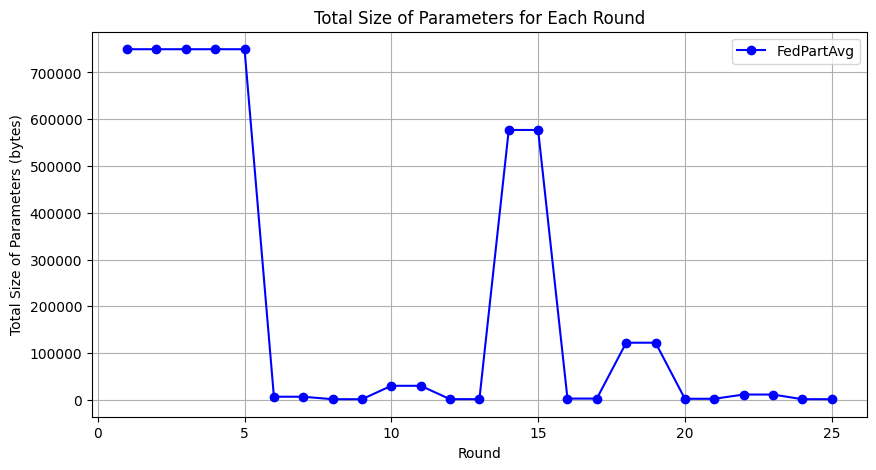

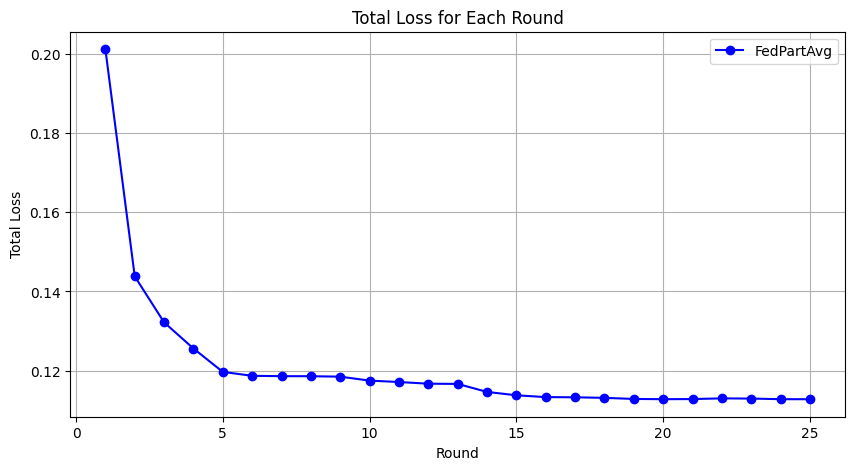

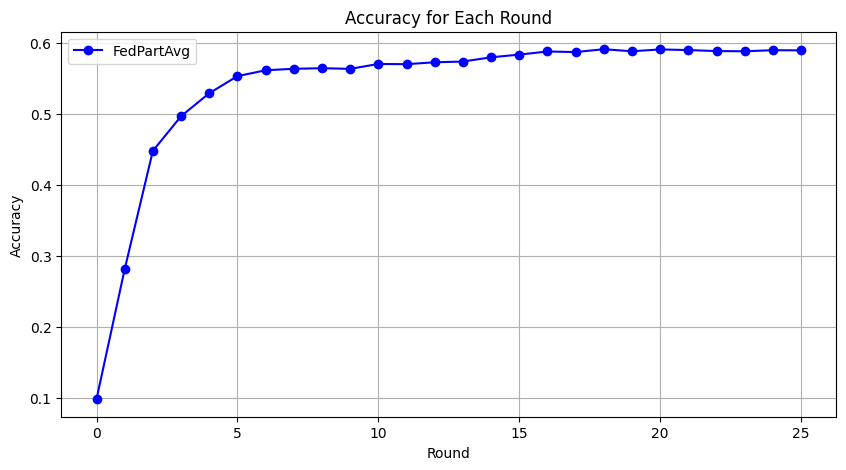

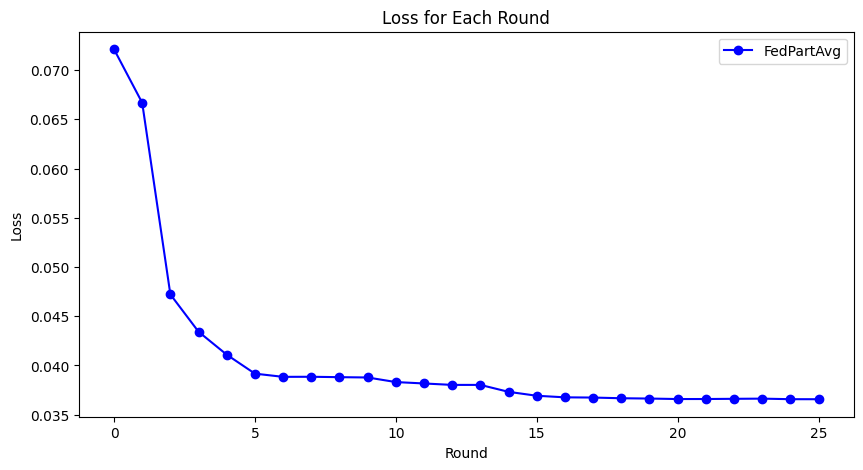

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the total size of parameters for each round
fed_part_avg_rounds = list(fed_part_avg_result.keys())
fed_part_avg_sizes = [fed_part_avg_result[round]["total_size"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='b', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_losses = [fed_part_avg_result[round]["total_loss"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


fed_part_avg_model_rounds = list(fed_part_avg_model_results.keys())
fed_part_avg_accuracies = [fed_part_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='b', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_global_losses = [fed_part_avg_model_results[round]["global_loss"] for round in fed_part_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for Each Round')


# FedProxPart Experiments

In [ ]:
class FedProxPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        freeze_layers(self.net, config["trainable_layers"])
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [ ]:
fed_part_prox_result = {}

fed_part_prox_model_results = {}

class FedPartProx(FedPartAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_size"] = total_size
        else:
            fed_part_prox_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated
    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_prox_model_results:  
            expand_fed_part_prox_model_results= {**fed_part_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_prox_model_results[server_round] = expand_fed_part_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [ ]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07214949100017548, {'accuracy': 0.1002}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=58486) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=58486) Epoch 1: train loss 0.05707049369812012, accuracy 0.3213321332133213
(ClientAppActor pid=58487) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58488) [Client 1] get_parameters
total size: 749760
(ClientAppActor pid=58487) Epoch 2: train loss 0.048956792801618576, accuracy 0.4322358058951474 [repeated 5x across cluster]


INFO :      fit progress: (1, 0.05436111489534378, {'accuracy': 0.4002}, 19.566051917005097)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=58488) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=58487) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58487) Epoch 1: train loss 0.04780459776520729, accuracy 0.44618615465386635
(ClientAppActor pid=58486) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58487) [Client 1] get_parameters
(ClientAppActor pid=58487) Epoch 2: train loss 0.04369639232754707, accuracy 0.4958373959348984 [repeated 3x across cluster]
total size: 749760


INFO :      fit progress: (2, 0.042602294147014615, {'accuracy': 0.511}, 36.70638212500489)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=58488) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Feb 23 20:40:10 2025).
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58488) [Client 1] evaluate, config: {}
(ClientAppActor pid=58486) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) Epoch 2: train loss 0.04368296638131142, accuracy 0.500262506562664 [repeated 2x across cluster]


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=58486, ip=127.0.0.1, actor_id=42841c142ba72c9f3d4ad43001000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x107d6ade0>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/datasets/uoft-cs/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=58486, ip=127.0.0.1, actor_id=42841c142ba72c9f3d4ad43001000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x107d6ade0>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/flwr/simulation/ray_transport

(ClientAppActor pid=58487) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 1 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=58487) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=58487) Epoch 1: train loss 0.042297717183828354, accuracy 0.5145128628215705
(ClientAppActor pid=58488) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=58487) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58488) Epoch 2: train loss 0.03918048366904259, accuracy 0.5498799879987999 [repeated 4x across cluster]
total size: 749760


INFO :      fit progress: (3, 0.039218665730953214, {'accuracy': 0.5534}, 83.37942283399752)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) Epoch 2: train loss 0.039707016199827194, accuracy 0.5400885022125553
(ClientAppActor pid=58487) Epoch 1: train loss 0.03869099169969559, accuracy 0.5536303630363036
(ClientAppActor pid=58488) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=58487) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58486) Epoch 2: train loss 0.0366257019340992, accuracy 0.5811145278631966 [repeated 5x across cluster]
total size: 749760


INFO :      fit progress: (4, 0.03773920437097549, {'accuracy': 0.5745}, 100.07098133399268)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58488) Epoch 1: train loss 0.036741599440574646, accuracy 0.582689567239181
(ClientAppActor pid=58488) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58487) Epoch 2: train loss 0.0339285284280777, accuracy 0.6098859885988599 [repeated 4x across cluster]
total size: 749760


INFO :      fit progress: (5, 0.03686101281642914, {'accuracy': 0.5848}, 116.90832516699447)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58486) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) Epoch 2: train loss 0.03416699916124344, accuracy 0.6109652741318533
(ClientAppActor pid=58488) Epoch 1: train loss 0.03273190185427666, accuracy 0.6291157278931974
(ClientAppActor pid=58487) [Client 0] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58486) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58487) [Client 0] get_parameters
total size: 6453


INFO :      fit progress: (6, 0.03662795833349228, {'accuracy': 0.5906}, 132.72479591699084)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58486) Epoch 2: train loss 0.032205503433942795, accuracy 0.6320132013201321 [repeated 5x across cluster]
(ClientAppActor pid=58488) [Client 2] evaluate, config: {}
(ClientAppActor pid=58487) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=58486) [Client 2] get_parameters
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=58487) Epoch 1: train loss 0.03217136487364769, accuracy 0.6348634863486349
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58488) Epoch 1: train loss 0.032753556966781616, accuracy 0.6324908122703068
(ClientAppActor pid=58487) [Client 2] get_parameters
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 6453


INFO :      fit progress: (7, 0.036501137471199034, {'accuracy': 0.5897}, 148.6708280419989)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58488) [Client 1] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.032575272023677826, accuracy 0.6297907447686192 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58487) Epoch 1: train loss 0.03235161677002907, accuracy 0.6324158103952598
(ClientAppActor pid=58488) Epoch 1: train loss 0.031906791031360626, accuracy 0.6368886888688869
(ClientAppActor pid=58486) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1} [repeated 2x across cluster]
(ClientAppActor pid=58487) [Client 1] get_parameters
(ClientAppActor pid=58488) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1125


INFO :      fit progress: (8, 0.03648419537544251, {'accuracy': 0.5917}, 161.56365925000864)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.03245016559958458, accuracy 0.632940823520588 [repeated 4x across cluster]
(ClientAppActor pid=58488) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=58486) [Client 0] get_parameters
(ClientAppActor pid=58486) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=58488) Epoch 1: train loss 0.03234030678868294, accuracy 0.6324908122703068
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58487) Epoch 1: train loss 0.031883604824543, accuracy 0.6371887188718872
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1125


INFO :      fit progress: (9, 0.03648078180551529, {'accuracy': 0.5922}, 174.59692966699367)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 1] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.0324578583240509, accuracy 0.6337658441461037 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=58486) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) Epoch 1: train loss 0.03275037556886673, accuracy 0.6312907822695567
(ClientAppActor pid=58487) Epoch 1: train loss 0.032215625047683716, accuracy 0.6350885088508851


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58487) [Client 2] get_parameters
total size: 29853


INFO :      fit progress: (10, 0.036300443863868714, {'accuracy': 0.594}, 187.0786389170098)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 1] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.03252822160720825, accuracy 0.6352658816470412 [repeated 4x across cluster]
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=58486) [Client 0] get_parameters
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=58487) Epoch 1: train loss 0.03193357214331627, accuracy 0.6353135313531353
(ClientAppActor pid=58488) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 1: train loss 0.03244197368621826, accuracy 0.628665716642916
(ClientAppActor pid=58487) [Client 2] get_parameters
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29853


INFO :      fit progress: (11, 0.036290678787231447, {'accuracy': 0.5951}, 199.63055520900525)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.032120946794748306, accuracy 0.6344408610215255 [repeated 4x across cluster]


(ClientAppActor pid=58486) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=58486) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Feb 23 20:40:10 2025).
(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 1] evaluate, config: {}
(ClientAppActor pid=58488) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=58488) Epoch 1: train loss 0.03190399706363678, accuracy 0.6420910522763069
(ClientAppActor pid=58488) Epoch 2: train loss 0.03184960409998894, accuracy 0.6436660916522913
(ClientAppActor pid=58488) [Client 0] get_parameters


(ClientAppActor pid=58486) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=58486) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Feb 23 20:40:10 2025).
(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=58486) Epoch 1: train loss 0.031674668192863464, accuracy 0.6400660016500412
(ClientAppActor pid=58486) Epoch 2: train loss 0.03164083510637283, accuracy 0.6414910372759319
(ClientAppActor pid=58486) [Client 1] get_parameters


(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=58487) Epoch 1: train loss 0.031223604455590248, accuracy 0.6475397539753975


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1245
(ClientAppActor pid=58487) Epoch 2: train loss 0.031170615926384926, accuracy 0.6466396639663966
(ClientAppActor pid=58487) [Client 2] get_parameters


INFO :      fit progress: (12, 0.03611619886159897, {'accuracy': 0.5966}, 240.9393897500122)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=58488) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=58488) Epoch 1: train loss 0.03163178265094757, accuracy 0.6432910822770569
(ClientAppActor pid=58486) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1245


INFO :      fit progress: (13, 0.036118165975809094, {'accuracy': 0.5954}, 254.02710408400162)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) Epoch 2: train loss 0.031153185293078423, accuracy 0.6471647164716472 [repeated 5x across cluster]
(ClientAppActor pid=58487) [Client 0] evaluate, config: {}
(ClientAppActor pid=58488) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=58488) Epoch 1: train loss 0.032810747623443604, accuracy 0.6271656791419785
(ClientAppActor pid=58486) [Client 2] evaluate, config: {}
(ClientAppActor pid=58487) Epoch 1: train loss 0.03234206885099411, accuracy 0.6323132313231323


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58488) [Client 0] get_parameters
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=58487) [Client 2] get_parameters
total size: 577053


INFO :      fit progress: (14, 0.035484035044908525, {'accuracy': 0.6056}, 266.36709833401255)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.03065778687596321, accuracy 0.6504912622815571 [repeated 4x across cluster]
(ClientAppActor pid=58486) [Client 1] get_parameters


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=58487) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) Epoch 1: train loss 0.03145241364836693, accuracy 0.6413410335258382
(ClientAppActor pid=58487) Epoch 1: train loss 0.031672850251197815, accuracy 0.6426160654016351
(ClientAppActor pid=58486) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 577053


INFO :      fit progress: (15, 0.035059994673728945, {'accuracy': 0.6096}, 279.6108799590147)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 1] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.02898053079843521, accuracy 0.6702670267026702 [repeated 4x across cluster]
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=58486) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=58487) Epoch 1: train loss 0.02885383926331997, accuracy 0.6760426042604261
(ClientAppActor pid=58488) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 1: train loss 0.029151491820812225, accuracy 0.6716417910447762
(ClientAppActor pid=58487) [Client 2] get_parameters
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58486) [Client 1] get_parameters
total size: 2493


INFO :      fit progress: (16, 0.03489087723493576, {'accuracy': 0.6147}, 292.4423024590069)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}
(ClientAppActor pid=58488) Epoch 2: train loss 0.029300609603524208, accuracy 0.6693917347933699 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=58488) [Client 0] get_parameters
(ClientAppActor pid=58488) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58487) Epoch 1: train loss 0.028695123270154, accuracy 0.6768676867686768
(ClientAppActor pid=58488) Epoch 1: train loss 0.02926493063569069, accuracy 0.670516762919073
(ClientAppActor pid=58487) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5} [repeated 2x across cluster]
total size: 2493


INFO :      fit progress: (17, 0.034886063706874845, {'accuracy': 0.6134}, 305.1299623340019)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.02895035222172737, accuracy 0.6744918622965574 [repeated 4x across cluster]
(ClientAppActor pid=58488) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=58487) Epoch 1: train loss 0.028866728767752647, accuracy 0.673042304230423
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 1: train loss 0.029414117336273193, accuracy 0.6672166804170104
(ClientAppActor pid=58487) [Client 2] get_parameters
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=58486) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 122013


INFO :      fit progress: (18, 0.035213052386045454, {'accuracy': 0.6147}, 317.7020292500092)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58488) [Client 0] evaluate, config: {}
(ClientAppActor pid=58488) Epoch 2: train loss 0.028522366657853127, accuracy 0.6756168904222606 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58487) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) Epoch 1: train loss 0.02869097702205181, accuracy 0.6727668191704793
(ClientAppActor pid=58487) Epoch 1: train loss 0.028986679390072823, accuracy 0.6725418135453386
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58486) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 122013


INFO :      fit progress: (19, 0.03517258603870869, {'accuracy': 0.6137}, 329.9216696670046)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58488) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.027952048927545547, accuracy 0.6826432643264326 [repeated 4x across cluster]
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58486) [Client 2] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=58488) Epoch 1: train loss 0.027851613238453865, accuracy 0.686018601860186
(ClientAppActor pid=58487) [Client 1] evaluate, config: {}
(ClientAppActor pid=58487) Epoch 1: train loss 0.028346411883831024, accuracy 0.6793669841746044
(ClientAppActor pid=58488) [Client 2] get_parameters
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2061


INFO :      fit progress: (20, 0.03513677633404732, {'accuracy': 0.6138}, 342.52670441698865)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 1] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.028058186173439026, accuracy 0.6824420610515263 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=58488) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) Epoch 1: train loss 0.02832283079624176, accuracy 0.6789169729243231
(ClientAppActor pid=58487) Epoch 1: train loss 0.027843503281474113, accuracy 0.6878187818781878
(ClientAppActor pid=58487) [Client 2] get_parameters
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=58488) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2061


INFO :      fit progress: (21, 0.03513615553975105, {'accuracy': 0.6131}, 355.02560520899715)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.02804466150701046, accuracy 0.6822170554263857 [repeated 4x across cluster]
(ClientAppActor pid=58488) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=58486) [Client 1] get_parameters
(ClientAppActor pid=58488) Epoch 1: train loss 0.028245985507965088, accuracy 0.6820670516762919
(ClientAppActor pid=58487) [Client 2] evaluate, config: {}
(ClientAppActor pid=58487) Epoch 1: train loss 0.02850561961531639, accuracy 0.6773419335483387
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 11133


INFO :      fit progress: (22, 0.0353413479089737, {'accuracy': 0.6133}, 366.99696349998703)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.027792956680059433, accuracy 0.6854935493549354 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=58486) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=58487) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) Epoch 1: train loss 0.028159353882074356, accuracy 0.6809420235505887
(ClientAppActor pid=58487) Epoch 1: train loss 0.028406687080860138, accuracy 0.6798169954248856


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58487) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=58487) [Client 0] get_parameters
total size: 11133


INFO :      fit progress: (23, 0.03542925624847412, {'accuracy': 0.6142}, 379.36877875000937)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58488) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.027783948928117752, accuracy 0.6872187218721872 [repeated 4x across cluster]
(ClientAppActor pid=58487) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=58486) [Client 2] get_parameters
(ClientAppActor pid=58487) Epoch 1: train loss 0.027947567403316498, accuracy 0.6831170779269482
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58488) Epoch 1: train loss 0.027683934196829796, accuracy 0.6879687968796879
(ClientAppActor pid=58487) [Client 1] get_parameters
(ClientAppActor pid=58486) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1173


INFO :      fit progress: (24, 0.035381616786122325, {'accuracy': 0.6153}, 391.7388833340083)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.028174255043268204, accuracy 0.6824420610515263 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=58488) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58486) Epoch 1: train loss 0.0279292743653059, accuracy 0.6828170704267607
(ClientAppActor pid=58487) Epoch 1: train loss 0.02763141505420208, accuracy 0.6875187518751875


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58487) [Client 2] get_parameters
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=58486) [Client 1] get_parameters
total size: 1173


INFO :      fit progress: (25, 0.03537553513050079, {'accuracy': 0.6142}, 403.8095760839933)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58488) [Client 0] evaluate, config: {}
(ClientAppActor pid=58488) Epoch 2: train loss 0.028166603296995163, accuracy 0.6828170704267607 [repeated 4x across cluster]
(ClientAppActor pid=58487) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 406.72s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05487831842420197
INFO :      		round 2: 0.042843286102234285
INFO :      		round 3: 0.039378589676561604
INFO :      		round 4: 0.03777413790379971
INFO :      		round 5: 0.036866777615055184
INFO :      		round 6: 0.03661153610468721
INFO :      		round 7: 0.03652657389676564
INFO :      		round 8: 0.03652669200358975
INFO :      		round 9: 0.036532075491291935
INFO :      		round 10: 0.036454162340096484
INFO :      		round 11: 0.036378585182054356
INFO :      		round 12: 0.03615573628726804
INFO :      		round 13: 0.03615000750143226
INFO :      		round 14: 0.03574542513378285
INFO :      		round 15: 0.03527100471985671
INFO :      		round 16: 0.035103856974948625
INFO :      		round 17: 0.035102613699350374
INFO :      		round 18: 0.035456362962007666
INFO :      		rou

(ClientAppActor pid=58488) [Client 0] get_parameters
(ClientAppActor pid=58486) [Client 2] evaluate, config: {}


(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


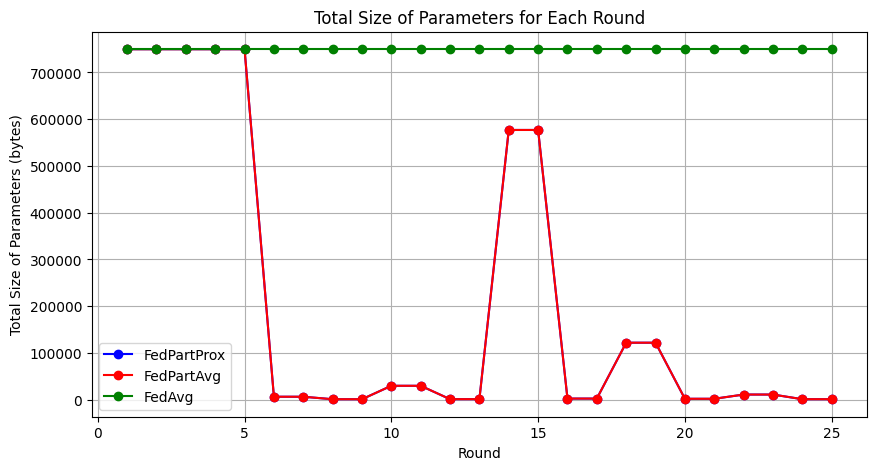

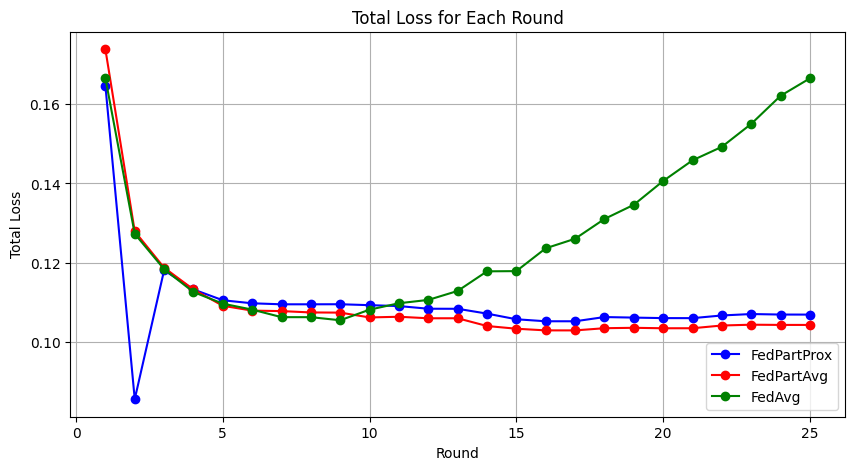

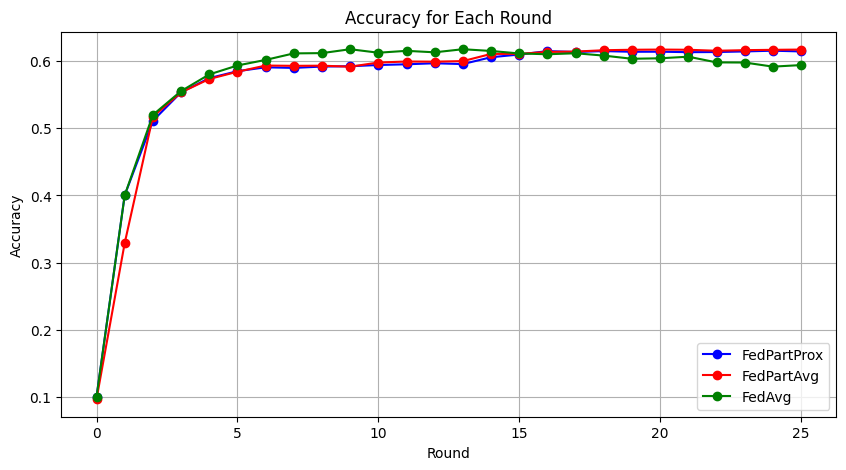

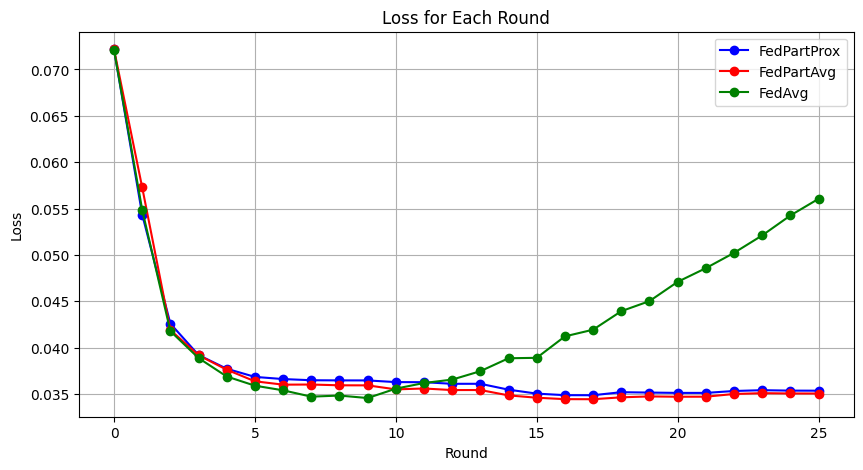

In [ ]:
fed_part_prox_rounds = list(fed_part_prox_result.keys())
fed_part_prox_sizes = [fed_part_prox_result[round]["total_size"] for round in fed_part_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_prox_losses = [fed_part_prox_result[round]["total_loss"] for round in fed_part_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


fed_part_prox_model_rounds = list(fed_part_prox_model_results.keys())
fed_part_prox_accuracies = [fed_part_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_prox_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_part_prox_global_losses = [fed_part_prox_model_results[round]["global_loss"] for round in fed_part_prox_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.legend()
plt.grid(True)




# FedMoon Experiments:

In [6]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_moon_result = {}
fed_moon_model_results = {}

# basically same as normal FedAvg, just added freezing and modified result dict names
class FedMoon(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedMoon"
    
    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        self.layer_training_sequence = self.generate_layer_training_sequence()
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        print(f"XXX IN EVALUATE")
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        print(f"XXX IN EVALUATE calling eval_res with params {parameters_ndarrays}")
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_moon_model_results:
            expand_fed_moon_result= {**fed_moon_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_moon_result= {"global_loss": loss, "global_metrics": metrics}

        fed_moon_model_results[server_round] = expand_fed_moon_result

        return loss, metrics


    def configure_fit(
        # includes layer freezing
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index]}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        
        if server_round in fed_moon_result:
            expand_fed_moon_result= {**fed_moon_result[server_round], "total_size": total_size}
        else:
            expand_fed_moon_result= {"total_size": total_size}

        fed_moon_result[server_round] = expand_fed_moon_result

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        
        aggregated_weights = aggregate(weights_results)
        
        if self.layer_training_sequence[self.training_sequence_index - 1] == -1:
            # Full model update
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            # Partial model update (single layer)
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index - 1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_moon_result:
            expand_fed_moon_result= {**fed_moon_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_moon_result= {"total_loss": total_loss}

        fed_moon_result[server_round] = expand_fed_moon_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [ ]:
import os

class FedMoonPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.model_dir = "models"

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")

        # load previous model
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            prev_model = copy.deepcopy(self.net)
        else:
            # initialise and load params from model_dir
            prev_model = type(self.net)() 
            prev_model.load_state_dict(
                torch.load(
                    os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt")
                )
            )

        # update params for current model (loading global params)
        set_parameters(self.net, parameters)

        # create global model (same params that were just loaded)
        global_model = type(self.net)()
        global_model.load_state_dict(self.net.state_dict())
        global_model.to(DEVICE)
        

        print(f"trainable layers: {config}")
        freeze_layers(self.net, config["trainable_layers"])
        train_moon(self.net, self.trainloader, global_model, prev_model, EPOCHS, 5, 0.5)

        # save current model 
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            os.makedirs(os.path.join(self.model_dir, str(self.partition_id)))
        torch.save(
            self.net.state_dict(),
            os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt"),
        )

        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test_moon(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = MoonNet().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedMoonPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

def get_evaluate_fn_moon(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test_moon(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate


In [8]:
# Train FedMOON


_, _, testloader = load_datasets(0, NUM_PARTITIONS)
net = MoonNet().to(DEVICE)
evaluate_fn = get_evaluate_fn_moon(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedMoon(
            evaluate_fn=evaluate_fn
        )
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.11225714, -0.06323406,  0.03130007,  0.09166131,
          -0.04352915],
         [ 0.03987798,  0.04649336, -0.10873298,  0.04714871,
           0.01544226],
         [ 0.08768368,  0.04889625, -0.0477993 , -0.02067335,
          -0.06719219],
         [ 0.03505212,  0.10805999, -0.05170312, -0.0384584 ,
          -0.04346682],
         [-0.01038748,  0.09154985, -0.10133353, -0.0135849 ,
          -0.03317585]],

        [[ 0.09861258,  0.06852838, -0.08676528,  0.01516603,
          -0.00100315],
         [-0.04996809, -0.09827469,  0.00388333,  0.10390078,
          -0.06416929],
         [ 0.01816494,  0.02644002,  0.025307  ,  0.00872815,
           0.03139497],
         [-0.09441009,  0.10285014, -0.05668721, -0.05384625,
           0.0135721 ],
         [-0.0162788 , -0.00746267, -0.04582174,  0.08826506,
           0.05785367]],

        [[-0.06611601,  0.10032199, -0.05694312,  0.00762762,
          -0

INFO :      initial parameters (loss, other metrics): 0.07217199640274048, {'accuracy': 0.1111}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88337) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=88337) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=88337) Started training moon
(ClientAppActor pid=88337) Epoch: 0 Loss: 2.834957 Loss1: 1.893354 Loss2: 0.941603
(ClientAppActor pid=88336) [Client 1] fit, config: {'trainable_layers': -1} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=88336) trainable layers: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=88336) Started training moon [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88336) parameters in this round: [array([[[[-1.91841975e-01, -1.36977702e-01, -1.65195223e-02,
(ClientAppActor pid=88336)            3.41593623e-02, -8.90114456e-02],
(ClientAppActor pid=88336)          [-1.93731748e-02,  5.93735650e-03, -1.08517624e-01,
(ClientAppActor pid=88336)            1.67834051e-02, -2.11147331e-02],
(ClientAppActor pid=88336)          [ 5.52974753e-02,  2.80456804e-02, -1.57707781e-02,
(ClientAppActor pid=88336)           -1.96303688e-02, -9.98407006e-02],
(ClientAppActor pid=88336)          [ 3.16452645e-02,  9.77043062e-02, -1.53100127e-02,
(ClientAppActor pid=88336)           -2.55192295e-02, -6.31878972e-02],
(ClientAppActor pid=88336)          [-9.98788979e-03,  9.10413712e-02, -7.93286562e-02,
(ClientAppActor pid=88336)           -1.68220624e-02, -5.69163784e-02]],
(ClientAppActor pid=88336) 
(ClientAppActor pid=88336)         [[ 9.75597836e-03, -1.46712912e-02, -1.41556963e-01,
(ClientAppActor pid=88336)           -4.88492139e-02, -5

INFO :      fit progress: (1, 0.04736277148723602, {'accuracy': 0.4524}, 21.779366834)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88335) [Client 0] evaluate, config: {}
(ClientAppActor pid=88335) parameters in this round: [array([[[[-1.69373080e-01, -1.21906593e-01,  6.86554890e-03,
(ClientAppActor pid=88335)       dtype=float32)] [repeated 1549x across cluster]
(ClientAppActor pid=88335)        [ 1.24619894e-01, -2.37566993e-01,  1.96954329e-02, [repeated 195x across cluster]
(ClientAppActor pid=88335)         [[ 6.05745763e-02,  6.55833911e-03, -3.45078856e-02, [repeated 38x across cluster]
(ClientAppActor pid=88335)        [[[ 6.27851207e-03,  9.32846032e-03,  2.86069233e-02, [repeated 13x across cluster]
(ClientAppActor pid=88337)            0.03673137]]]], dtype=float32), array([ 0.02775639, -0.02753141, -0.0120965 , -0.04262023,  0.14975327,
(ClientAppActor pid=88335)        [-0.02989506, -0.08183532,  0.01309869, ...,  0.00749551, [repeated 21x across cluster]
(ClientAppActor pid=88335)         0.05817253, -0.0748111 , -0.03631271,  0.12693581, -0.12187747], [repeated 42x across cluster

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88337) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=88337) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=88337) Started training moon
(ClientAppActor pid=88336) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=88337) Epoch: 0 Loss: 4.723768 Loss1: 1.503191 Loss2: 3.220577
(ClientAppActor pid=88336) [Client 0] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=88336) trainable layers: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=88336) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=88335) Epoch: 0 Loss: 4.612869 Loss1: 1.463246 Loss2: 3.149623
(ClientAppActor pid=88337) Epoch: 1 Loss: 4.539543 Loss1: 1.388890 Loss2: 3.150653 [repeated 2x across cluster]
(ClientAppActor pid=88337) parameters in this round: [arra

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88336)        [ 0.0111418 ,  0.01628415, -0.00350321, ..., -0.0483098 ,
(ClientAppActor pid=88336)        [-0.1289367 , -0.0187677 , -0.01261556, ...,  0.06478002,
(ClientAppActor pid=88336)          0.02953411,  0.04535036]], dtype=float32), array([ 0.00117215, -0.05446124, -0.041565  ,  0.00632315,  0.01939713,
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-1.86239064e-01, -1.46049768e-01, -1.78594962e-02,
           2.70634387e-02, -7.77567253e-02],
         [-1.23320911e-02,  3.21971765e-03, -1.05211459e-01,
           8.01618304e-03, -2.46038307e-02],
         [ 5.92436530e-02,  2.89513655e-02, -5.60390018e-03,
          -2.08625402e-02, -1.12980552e-01],
         [ 2.88027208e-02,  9.26128626e-02, -1.17168613e-02,
          -2.79256701e-02, -7.82916173e-02],
         [-2.04127096e-02,  8.14839974e-02, -8.30251426e-02,
          -3.16528082e-02, -7.94317275e-02]],

        [[ 2.97446549e-03, -3.26106958e-02, -1.49217948e-01,
          

INFO :      fit progress: (2, 0.042628434300422666, {'accuracy': 0.5056}, 43.684152667)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88336) [Client 0] evaluate, config: {}
(ClientAppActor pid=88336) Epoch: 1 Loss: 4.604079 Loss1: 1.390650 Loss2: 3.213429 [repeated 2x across cluster]
(ClientAppActor pid=88336)       dtype=float32)] [repeated 1594x across cluster]
(ClientAppActor pid=88336)        [ 1.31548479e-01, -2.51264066e-01,  1.37585327e-02, [repeated 201x across cluster]
(ClientAppActor pid=88336)          0.05874898, -0.0327906 ], [repeated 2x across cluster]
(ClientAppActor pid=88336)        [[[ 2.19738502e-02,  4.06990908e-02,  5.57322390e-02, [repeated 15x across cluster]
(ClientAppActor pid=88336)         [[ 7.00735748e-02, -4.01459895e-02, -9.33417231e-02, [repeated 41x across cluster]
(ClientAppActor pid=88336)         0.00683994,  0.09475137,  0.02163673, -0.09350134,  0.021163  , [repeated 15x across cluster]
(ClientAppActor pid=88336)        -0.07390943, -0.0909942 ,  0.03034994,  0.00771691, -0.0359319 , [repeated 4x across cluster]
(ClientAppActor pid=88336)          0.04785935,

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88336) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=88337) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=88337) Started training moon
(ClientAppActor pid=88337) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=88336) Epoch: 0 Loss: 3.008144 Loss1: 1.332127 Loss2: 1.676017
(ClientAppActor pid=88335) [Client 1] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=88336) trainable layers: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=88336) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=88337) Epoch: 0 Loss: 3.021737 Loss1: 1.356106 Loss2: 1.665631
(ClientAppActor pid=88336) parameters in this round: [array([[[[-0.18412596, -0.14994816, -0.01483322,  0.03149908,
(ClientAppActor pid=88336)           -0.05322598],
(Cl

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88337)        [ 0.0334305 ,  0.04437925,  0.0027582 , ..., -0.05832244,
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-1.83184490e-01, -1.52696818e-01, -2.19040550e-02,
           2.11147014e-02, -6.84539452e-02],
         [-1.62785966e-02, -3.67236231e-03, -1.07602075e-01,
          -9.14119300e-04, -2.54078694e-02],
         [ 4.09081392e-02,  8.29043798e-03, -1.24618486e-02,
          -2.74966434e-02, -1.26919284e-01],
         [ 1.17817558e-02,  6.69245273e-02, -2.58919392e-02,
          -4.01888750e-02, -9.62878019e-02],
         [-4.39778119e-02,  5.47560565e-02, -1.04577519e-01,
          -5.80172166e-02, -1.11643597e-01]],

        [[ 1.69032067e-03, -4.12075408e-02, -1.52741089e-01,
          -6.68483675e-02, -3.85248438e-02],
         [-1.22273862e-01, -1.48461953e-01,  1.60771627e-02,
           6.11904077e-02, -1.09161548e-01],
         [-3.27343792e-02, -2.06609815e-03,  8.52616280e-02,
           2.15481259e-02, -2.73949206e-0

INFO :      fit progress: (3, 0.0401140138566494, {'accuracy': 0.539}, 64.93167449999999)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88336) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88335) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=88335) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=88335) Started training moon
(ClientAppActor pid=88335) parameters in this round: [array([[[[-1.93891391e-01, -1.60822138e-01, -3.20223905e-02, [repeated 2x across cluster]
(ClientAppActor pid=88336)  [repeated 1543x across cluster]
(ClientAppActor pid=88335)        [ 1.52420729e-01, -2.50927925e-01,  2.13985890e-02, [repeated 202x across cluster]
(ClientAppActor pid=88337)          [ 0.09568104, -0.0509815 ,  0.01560382,  0.00061956, [repeated 7x across cluster]
(ClientAppActor pid=88335)         0.03637505, -0.0646456 , -0.13056062,  0.21192543, -0.17567566], [repeated 41x across cluster]
(ClientAppActor pid=88337)            0.065387  ]]],
(ClientAppActor pid=88335)        [[[ 3.10708974e-02,  5.07549606e-02,  5.34193031e-

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88337)          [ 0.02787867, -0.00510835, -0.00911889, -0.0255022 ,
(ClientAppActor pid=88337)         [[ 0.0116585 , -0.04716422, -0.15483293, -0.07378325,
(ClientAppActor pid=88337)          [ 0.08673102,  0.15663917,  0.2607539 ,  0.28686818,
(ClientAppActor pid=88337)          [ 0.0602256 ,  0.10063898,  0.2522055 ,  0.19856298,
(ClientAppActor pid=88337)          [ 0.09736834,  0.0120701 , -0.19741082,  0.01766094,
(ClientAppActor pid=88337)          [ 0.2279356 ,  0.05476619, -0.00091792, -0.00372207,
(ClientAppActor pid=88337)         [[ 0.0477814 , -0.17624852, -0.1416485 ,  0.02264425,
(ClientAppActor pid=88337)          [ 0.17529331,  0.1014604 , -0.07048799, -0.16966908,
(ClientAppActor pid=88337)           -0.0802625 ]],
(ClientAppActor pid=88337)          [ 0.08986626,  0.10666582, -0.07585416, -0.0662486 ,
(ClientAppActor pid=88337)          [ 0.26742747, -0.01441868, -0.05817367, -0.0237922 ,
(ClientAppActor pid=88337)          [ 0.1025722 ,  0.15860

INFO :      fit progress: (4, 0.03863066281080246, {'accuracy': 0.5649}, 85.78181508399999)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88336) [Client 2] evaluate, config: {}
(ClientAppActor pid=88337) Epoch: 1 Loss: 2.700801 Loss1: 1.193728 Loss2: 1.507073 [repeated 2x across cluster]
(ClientAppActor pid=88337) parameters in this round: [array([[[[-0.16611014, -0.15618402, -0.02183448,  0.01621103, [repeated 2x across cluster]
(ClientAppActor pid=88337)       dtype=float32)] [repeated 1362x across cluster]
(ClientAppActor pid=88337)        [ 0.21178743, -0.29992023,  0.02139859, -0.05316767,  0.09007902, [repeated 193x across cluster]
(ClientAppActor pid=88337)        [[[ 1.42255388e-02,  4.87395190e-02,  5.35468236e-02, [repeated 14x across cluster]
(ClientAppActor pid=88337)         [[ 6.42427281e-02, -6.89333156e-02, -1.29935190e-01, [repeated 42x across cluster]
(ClientAppActor pid=88337)        [-0.08156867, -0.01626624, -0.08839384, ..., -0.08882844, [repeated 12x across cluster]
(ClientAppActor pid=88337)         0.04202284, -0.13712841, -0.09320319,  0.2392857 , -0.16315669], [repeated 97x 

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88337) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=88337) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=88337) Started training moon
(ClientAppActor pid=88335) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=88337) Epoch: 0 Loss: 2.794080 Loss1: 1.210873 Loss2: 1.583207
(ClientAppActor pid=88336) [Client 2] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=88336) trainable layers: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=88336) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=88336) Epoch: 0 Loss: 2.842952 Loss1: 1.195210 Loss2: 1.647742
(ClientAppActor pid=88336) parameters in this round: [array([[[[-1.68674022e-01, -1.52808711e-01, -1.70497205e-02,
(ClientAppActor pid=88336)            2.15740353e-02, -

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-1.65734157e-01, -1.51789144e-01, -1.97627116e-02,
           1.71963815e-02, -5.30304834e-02],
         [-1.05783185e-02, -4.28876886e-03, -1.10891923e-01,
          -1.44817494e-02, -2.63842456e-02],
         [ 2.28308234e-02, -1.12921363e-02, -2.59963255e-02,
          -4.38344814e-02, -1.49575785e-01],
         [-5.00737783e-03,  3.94888148e-02, -5.08530810e-02,
          -6.29014745e-02, -1.20386697e-01],
         [-8.40131491e-02,  2.16410421e-02, -1.40292302e-01,
          -1.01064093e-01, -1.61692336e-01]],

        [[ 3.56812263e-03, -4.99410219e-02, -1.56335622e-01,
          -7.56365135e-02, -3.03336028e-02],
         [-1.20224111e-01, -1.40274718e-01,  2.84852982e-02,
           6.60414696e-02, -1.02261439e-01],
         [-4.25347276e-02, -3.68239387e-04,  1.02625892e-01,
           3.86718512e-02, -2.95759905e-02],
         [-1.15452819e-01,  8.03986639e-02,  9.83079243e-03,
          -1.46576194e-02, 

INFO :      fit progress: (5, 0.03830955409407616, {'accuracy': 0.5752}, 106.522085167)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88335) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88337) [Client 0] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=88337) trainable layers: {'trainable_layers': 0}
(ClientAppActor pid=88337) Started training moon
(ClientAppActor pid=88335) parameters in this round: [array([[[[-1.58273965e-01, -1.50049955e-01, -1.70720126e-02,
(ClientAppActor pid=88335)       dtype=float32)] [repeated 1529x across cluster]
(ClientAppActor pid=88335)        [ 2.65415549e-01, -2.88326710e-01,  2.13985909e-02, [repeated 194x across cluster]
(ClientAppActor pid=88335)        [[[ 1.59892049e-02,  5.02710268e-02,  5.38680106e-02, [repeated 12x across cluster]
(ClientAppActor pid=88335)         [[ 5.43603860e-02, -8.76935571e-02, -1.37086466e-01, [repeated 42x across cluster]
(ClientAppActor pid=88335)           -6.66380003e-02, -3.51060741e-02]]]], dtype=float32), array([ 0.19371065, -0.04028315, -0.05528152, -0.15097906,  0.183527

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88335) parameters in this round: [array([[[[-1.34488985e-01, -1.36561856e-01, -2.41736881e-02,
(ClientAppActor pid=88335)            3.25003383e-03, -5.39159514e-02],
(ClientAppActor pid=88335)          [-3.53142293e-03, -1.29525820e-02, -1.35574549e-01,
(ClientAppActor pid=88335)           -3.88192050e-02, -1.80924404e-02],
(ClientAppActor pid=88335)          [ 2.17595547e-02, -3.52924764e-02, -6.87073842e-02,
(ClientAppActor pid=88335)           -7.31744394e-02, -1.37264907e-01],
(ClientAppActor pid=88335)          [-3.05532664e-03,  1.31892608e-02, -9.30148214e-02,
(ClientAppActor pid=88335)           -9.41313058e-02, -1.17730647e-01],
(ClientAppActor pid=88335)          [-8.95749480e-02, -2.89057661e-03, -1.77333951e-01,
(ClientAppActor pid=88335)           -1.37581900e-01, -1.81071669e-01]],
(ClientAppActor pid=88335) 
(ClientAppActor pid=88335)         [[ 3.98503281e-02, -2.61866115e-02, -1.46089166e-01,
(ClientAppActor pid=88335)           -7.36204907e-02, -1

INFO :      fit progress: (6, 0.0379536654651165, {'accuracy': 0.5757}, 126.29619124999999)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88337) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88336) [Client 1] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=88336) trainable layers: {'trainable_layers': 0}
(ClientAppActor pid=88336) Started training moon
(ClientAppActor pid=88337) parameters in this round: [array([[[[-1.56255201e-01, -1.46575078e-01, -4.48430562e-03, [repeated 2x across cluster]
(ClientAppActor pid=88337)       dtype=float32)] [repeated 1554x across cluster]
(ClientAppActor pid=88337)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 211x across cluster]
(ClientAppActor pid=88337)         [[ 5.96444719e-02, -9.01199207e-02, -1.37633994e-01, [repeated 41x across cluster]
(ClientAppActor pid=88337)        [[[ 2.40653418e-02,  5.74621558e-02,  5.95593527e-02, [repeated 14x across cluster]
(ClientAppActor pid=88337)           -1.05754465e-01, -8.77061635e-02]]]], dtype=float32), array([ 0.19649641, -0.04051578, -0.058

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88337)          [ 0.02310028, -0.06237514, -0.081491  , -0.08103221,
(ClientAppActor pid=88337)           -0.1122068 ],
(ClientAppActor pid=88337)         [[ 0.03631852, -0.04446483, -0.1475239 , -0.07829974,
(ClientAppActor pid=88337)           -0.0049463 ],
(ClientAppActor pid=88337)            0.2084904 ],
(ClientAppActor pid=88337)            0.132227  ],
(ClientAppActor pid=88337)          [ 0.1252339 ,  0.14104444,  0.2715386 ,  0.20840326,
(ClientAppActor pid=88337)            0.0995677 ]]],
(ClientAppActor pid=88337)           -0.022613  ],
(ClientAppActor pid=88337)          [ 0.07373798, -0.00662254, -0.1939165 ,  0.05412159,
(ClientAppActor pid=88337)            0.0454871 ],
(ClientAppActor pid=88337)          [ 0.16300547,  0.12757638, -0.0440438 , -0.0949723 ,
(ClientAppActor pid=88337)          [ 0.05947671,  0.11562778,  0.13208197, -0.0316018 ,
(ClientAppActor pid=88337)          [ 0.05736426,  0.15270524, -0.0295227 , -0.09344283,
(ClientAppActor pi

INFO :      fit progress: (7, 0.037663702231645585, {'accuracy': 0.5758}, 146.367373709)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88336) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88335) [Client 0] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=88335) parameters in this round: [array([[[[-1.67803273e-01, -1.78978547e-01, -5.40662222e-02, [repeated 2x across cluster]
(ClientAppActor pid=88335)       dtype=float32)] [repeated 1523x across cluster]
(ClientAppActor pid=88335)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 201x across cluster]
(ClientAppActor pid=88335)        [[[ 2.40653418e-02,  5.74621558e-02,  5.95593527e-02, [repeated 10x across cluster]
(ClientAppActor pid=88335)         [[ 5.96444719e-02, -9.01199207e-02, -1.37633994e-01, [repeated 42x across cluster]
(ClientAppActor pid=88335)           -5.08042760e-02, -1.08440509e-02]]]], dtype=float32), array([ 0.19649641, -0.04051578, -0.05847944, -0.15829112,  0.1852528 , [repeated 2x across cluster]
(ClientAppActor pid=88335)        [-0.08870449, -0.01783

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88335)           -0.04577251]]]], dtype=float32), array([ 0.14917581, -0.06836559,  0.04971195, -0.04943423,  0.2206544 ,
(ClientAppActor pid=88335) Epoch: 1 Loss: 4.286068 Loss1: 1.211853 Loss2: 3.074215 [repeated 4x across cluster]
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
          -0.03368702],
         [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
          -0.01727196],
         [ 0.00795726, -0.04857474, -0.06243014, -0.06469207,
          -0.14231452],
         [-0.0212213 , -0.00892594, -0.0986701 , -0.09442867,
          -0.11822166],
         [-0.10044256, -0.00984198, -0.17606372, -0.13162038,
          -0.16624208]],

        [[-0.00314454, -0.0695696 , -0.16602144, -0.08761337,
          -0.02780153],
         [-0.12525487, -0.15136406,  0.02023078,  0.05823724,
          -0.09146705],
         [-0.05428226, -0.02239306,  0.08587946,  0.04201037,
          -0.00378

INFO :      fit progress: (8, 0.03762688543200493, {'accuracy': 0.5754}, 164.075578209)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88335) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88337) [Client 2] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=88337) trainable layers: {'trainable_layers': 1}
(ClientAppActor pid=88337) Started training moon
(ClientAppActor pid=88337) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 , [repeated 2x across cluster]
(ClientAppActor pid=88337)       dtype=float32)] [repeated 1508x across cluster]
(ClientAppActor pid=88337)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 184x across cluster]
(ClientAppActor pid=88337)        -0.16343734, -0.0853921 ,  0.06708898,  0.2051382 ,  0.02096593, [repeated 12x across cluster]
(ClientAppActor pid=88337)        -0.0328422 , -0.08574574, -0.14920217, -0.06330102], dtype=float32), array([[-1.16407230e-01,  1.39530882e-01, -6.95719644e-02, [repeated 64x across cluster]
(ClientAppActor pid=88337)         0.0435773

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88335) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
(ClientAppActor pid=88335)            0.4201285 ]]],
(ClientAppActor pid=88335)            0.1980726 ]],
(ClientAppActor pid=88335)         [[ 0.03891246, -0.1569704 , -0.13139781, -0.0641247 ,
(ClientAppActor pid=88335)         [[ 0.11442687,  0.1438988 , -0.10886049,  0.16678254,
(ClientAppActor pid=88335)           -0.04577251]]]], dtype=float32), array([ 0.27302593, -0.07472285, -0.20118155, -0.34154198,  0.21190192,
(ClientAppActor pid=88335)         0.18938412, -0.0071417 , -0.05334383,  0.207414  , -0.0060536 ,
(ClientAppActor pid=88335)       dtype=float32), array([[ 0.02414791,  0.06336722, -0.00023522, ..., -0.04215519,
(ClientAppActor pid=88335)        [-0.10989808, -0.0280169 ,  0.03545006, ..., -0.01724631,
(ClientAppActor pid=88335) [Client 0] get_parameters
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.

INFO :      fit progress: (9, 0.037611473840475085, {'accuracy': 0.5749}, 181.438774125)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88337) Epoch: 1 Loss: 4.227516 Loss1: 1.175050 Loss2: 3.052466 [repeated 5x across cluster]
(ClientAppActor pid=88336) [Client 2] evaluate, config: {}
(ClientAppActor pid=88337) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88336) [Client 2] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=88336) trainable layers: {'trainable_layers': 2}
(ClientAppActor pid=88336) Started training moon
(ClientAppActor pid=88337)       dtype=float32)] [repeated 1509x across cluster]
(ClientAppActor pid=88337)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 184x across cluster]
(ClientAppActor pid=88337)        -0.16343734, -0.0853921 ,  0.06708898,  0.2051382 ,  0.02096593, [repeated 12x across cluster]
(ClientAppActor pid=88337)        -0.0328422 , -0.08574574, -0.14920217, -0.06330102], dtype=float32), array([[-1.16407230e-01,  1.39530882e-01, -6.95719644e-02, [repeated 64x across cluster]
(ClientAppActor pid=88337)            0.1827408 ], [repeated 17x across cluster]
(ClientAppActor pid=88337)          [ 0.07269642,  0.30489302,  0.09792047,  0.2748244 , [repeated 26x acros

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
          -0.03368702],
         [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
          -0.01727196],
         [ 0.00795726, -0.04857474, -0.06243014, -0.06469207,
          -0.14231452],
         [-0.0212213 , -0.00892594, -0.0986701 , -0.09442867,
          -0.11822166],
         [-0.10044256, -0.00984198, -0.17606372, -0.13162038,
          -0.16624208]],

        [[-0.00314454, -0.0695696 , -0.16602144, -0.08761337,
          -0.02780153],
         [-0.12525487, -0.15136406,  0.02023078,  0.05823724,
          -0.09146705],
         [-0.05428226, -0.02239306,  0.08587946,  0.04201037,
          -0.00378072],
         [-0.11572058,  0.0559753 , -0.01037658, -0.01533975,
           0.00177059],
         [-0.07093461, -0.03253077, -0.02233085,  0.05972584,
          -0.01892897]],

        [[-0.08669093,  0.07431647,  0.00059119,  0.03568311,
           0

INFO :      fit progress: (10, 0.03732555683851242, {'accuracy': 0.5791}, 198.21089104200001)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88337) [Client 1] evaluate, config: {}
(ClientAppActor pid=88335) Epoch: 1 Loss: 4.184547 Loss1: 1.218474 Loss2: 2.966074 [repeated 4x across cluster]
(ClientAppActor pid=88335) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 , [repeated 2x across cluster]
(ClientAppActor pid=88335)            0.4201285 ]]], [repeated 2x across cluster]
(ClientAppActor pid=88335)            0.1980726 ]], [repeated 2x across cluster]
(ClientAppActor pid=88335)         [[ 0.03891246, -0.1569704 , -0.13139781, -0.0641247 , [repeated 2x across cluster]
(ClientAppActor pid=88335)         [[ 0.11442687,  0.1438988 , -0.10886049,  0.16678254, [repeated 2x across cluster]
(ClientAppActor pid=88335)           -0.04577251]]]], dtype=float32), array([ 0.20998265, -0.08565624, -0.07452385, -0.17370868,  0.22115703, [repeated 2x across cluster]
(ClientAppActor pid=88335)         0.18938412, -0.0071417 , -0.05334383,  0.207414  , -0.0060536 , [repeated 2x ac

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88335) [Client 1] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=88335) trainable layers: {'trainable_layers': 2}
(ClientAppActor pid=88335) Started training moon
(ClientAppActor pid=88336) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=88335) Epoch: 0 Loss: 4.016247 Loss1: 1.244842 Loss2: 2.771405
(ClientAppActor pid=88336) 
(ClientAppActor pid=88336) Epoch: 0 Loss: 4.036627 Loss1: 1.201330 Loss2: 2.835296
(ClientAppActor pid=88337) [Client 2] fit, config: {'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=88337) trainable layers: {'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=88337) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=88335) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
(ClientAppActor pid=88335)    

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
          -0.03368702],
         [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
          -0.01727196],
         [ 0.00795726, -0.04857474, -0.06243014, -0.06469207,
          -0.14231452],
         [-0.0212213 , -0.00892594, -0.0986701 , -0.09442867,
          -0.11822166],
         [-0.10044256, -0.00984198, -0.17606372, -0.13162038,
          -0.16624208]],

        [[-0.00314454, -0.0695696 , -0.16602144, -0.08761337,
          -0.02780153],
         [-0.12525487, -0.15136406,  0.02023078,  0.05823724,
          -0.09146705],
         [-0.05428226, -0.02239306,  0.08587946,  0.04201037,
          -0.00378072],
         [-0.11572058,  0.0559753 , -0.01037658, -0.01533975,
           0.00177059],
         [-0.07093461, -0.03253077, -0.02233085,  0.05972584,
          -0.01892897]],

        [[-0.08669093,  0.07431647,  0.00059119,  0.03568311,
           0

INFO :      fit progress: (11, 0.03713254874944687, {'accuracy': 0.5806}, 215.35515079200002)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88337) [Client 0] evaluate, config: {}
(ClientAppActor pid=88337) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 , [repeated 2x across cluster]
(ClientAppActor pid=88337)       dtype=float32)] [repeated 1496x across cluster]
(ClientAppActor pid=88337)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 189x across cluster]
(ClientAppActor pid=88337)        -0.16343734, -0.0853921 ,  0.06708898,  0.2051382 ,  0.02096593, [repeated 12x across cluster]
(ClientAppActor pid=88337)        -0.0328422 , -0.08574574, -0.14920217, -0.06330102], dtype=float32), array([[-1.16407230e-01,  1.39530882e-01, -6.95719644e-02, [repeated 64x across cluster]
(ClientAppActor pid=88337)         0.109112  ], dtype=float32), array([[[[-1.89530075e-01, -1.25414550e-01, -1.41512439e-01, [repeated 18x across cluster]
(ClientAppActor pid=88337)          [ 0.07269642,  0.30489302,  0.09792047,  0.2748244 , [repeated 26x across cluster]
(Cl

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88335) [Client 1] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=88335) trainable layers: {'trainable_layers': 3}
(ClientAppActor pid=88335) Started training moon
(ClientAppActor pid=88336) Epoch: 0 Loss: 4.070416 Loss1: 1.181943 Loss2: 2.888473
(ClientAppActor pid=88336) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=88337) [Client 2] fit, config: {'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=88337) trainable layers: {'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=88337) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=88336) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
(ClientAppActor pid=88336)           -0.03368702],
(ClientAppActor pid=88336)          [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
(

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
          -0.03368702],
         [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
          -0.01727196],
         [ 0.00795726, -0.04857474, -0.06243014, -0.06469207,
          -0.14231452],
         [-0.0212213 , -0.00892594, -0.0986701 , -0.09442867,
          -0.11822166],
         [-0.10044256, -0.00984198, -0.17606372, -0.13162038,
          -0.16624208]],

        [[-0.00314454, -0.0695696 , -0.16602144, -0.08761337,
          -0.02780153],
         [-0.12525487, -0.15136406,  0.02023078,  0.05823724,
          -0.09146705],
         [-0.05428226, -0.02239306,  0.08587946,  0.04201037,
          -0.00378072],
         [-0.11572058,  0.0559753 , -0.01037658, -0.01533975,
           0.00177059],
         [-0.07093461, -0.03253077, -0.02233085,  0.05972584,
          -0.01892897]],

        [[-0.08669093,  0.07431647,  0.00059119,  0.03568311,
           0

INFO :      fit progress: (12, 0.03719945091605186, {'accuracy': 0.5792}, 231.89093241700002)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88337) Epoch: 1 Loss: 3.938337 Loss1: 1.172616 Loss2: 2.765722 [repeated 5x across cluster]
(ClientAppActor pid=88335) [Client 1] evaluate, config: {}
(ClientAppActor pid=88336) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88335) [Client 1] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=88335) trainable layers: {'trainable_layers': 3}
(ClientAppActor pid=88335) Started training moon
(ClientAppActor pid=88337) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 , [repeated 2x across cluster]
(ClientAppActor pid=88337)       dtype=float32)] [repeated 1496x across cluster]
(ClientAppActor pid=88337)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 190x across cluster]
(ClientAppActor pid=88337)        -0.16343734, -0.0853921 ,  0.06708898,  0.2051382 ,  0.02096593, [repeated 12x across cluster]
(ClientAppActor pid=88337)        -0.0328422 , -0.08574574, -0.14920217, -0.06330102], dtype=float32), array([[-1.16407230e-01,  1.39530882e-01, -6.95719644e-02, [repeated 63x across cluster]
(ClientAppActor pid=88337)         0.109112 

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
          -0.03368702],
         [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
          -0.01727196],
         [ 0.00795726, -0.04857474, -0.06243014, -0.06469207,
          -0.14231452],
         [-0.0212213 , -0.00892594, -0.0986701 , -0.09442867,
          -0.11822166],
         [-0.10044256, -0.00984198, -0.17606372, -0.13162038,
          -0.16624208]],

        [[-0.00314454, -0.0695696 , -0.16602144, -0.08761337,
          -0.02780153],
         [-0.12525487, -0.15136406,  0.02023078,  0.05823724,
          -0.09146705],
         [-0.05428226, -0.02239306,  0.08587946,  0.04201037,
          -0.00378072],
         [-0.11572058,  0.0559753 , -0.01037658, -0.01533975,
           0.00177059],
         [-0.07093461, -0.03253077, -0.02233085,  0.05972584,
          -0.01892897]],

        [[-0.08669093,  0.07431647,  0.00059119,  0.03568311,
           0

INFO :      fit progress: (13, 0.037026431834697726, {'accuracy': 0.5816}, 247.74954562500002)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88336) [Client 2] evaluate, config: {}
(ClientAppActor pid=88337) Epoch: 1 Loss: 4.094603 Loss1: 1.175901 Loss2: 2.918702 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88335) [Client 0] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=88335) trainable layers: {'trainable_layers': 4}
(ClientAppActor pid=88335) Started training moon
(ClientAppActor pid=88335)         0.1803038 ], dtype=float32), array([[-0.02657615, -0.03643772,  0.03927985, ..., -0.08444262,
(ClientAppActor pid=88337)       dtype=float32)] [repeated 1494x across cluster]
(ClientAppActor pid=88337)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 190x across cluster]
(ClientAppActor pid=88337)        -0.16343734, -0.0853921 ,  0.06708898,  0.2051382 ,  0.02096593, [repeated 14x across cluster]
(ClientAppActor pid=88337)        -0.0328422 , -0.08574574, -0.14920217, -0.06330102], dtype=float32), array([[-1.16407230e-01,  1.39530882e-01, -6.95719644e-02, [repeated 62x across cluster]
(ClientAppActor pid=88337)         0.109112  ], dtype=float3

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
          -0.03368702],
         [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
          -0.01727196],
         [ 0.00795726, -0.04857474, -0.06243014, -0.06469207,
          -0.14231452],
         [-0.0212213 , -0.00892594, -0.0986701 , -0.09442867,
          -0.11822166],
         [-0.10044256, -0.00984198, -0.17606372, -0.13162038,
          -0.16624208]],

        [[-0.00314454, -0.0695696 , -0.16602144, -0.08761337,
          -0.02780153],
         [-0.12525487, -0.15136406,  0.02023078,  0.05823724,
          -0.09146705],
         [-0.05428226, -0.02239306,  0.08587946,  0.04201037,
          -0.00378072],
         [-0.11572058,  0.0559753 , -0.01037658, -0.01533975,
           0.00177059],
         [-0.07093461, -0.03253077, -0.02233085,  0.05972584,
          -0.01892897]],

        [[-0.08669093,  0.07431647,  0.00059119,  0.03568311,
           0

INFO :      fit progress: (14, 0.03630236198306084, {'accuracy': 0.5927}, 263.69364887499995)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88336) [Client 1] evaluate, config: {}
(ClientAppActor pid=88337) Epoch: 1 Loss: 3.806750 Loss1: 1.121914 Loss2: 2.684836 [repeated 4x across cluster]
(ClientAppActor pid=88337) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88337) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 , [repeated 2x across cluster]
(ClientAppActor pid=88337)            0.4201285 ]]], [repeated 2x across cluster]
(ClientAppActor pid=88337)            0.1980726 ]], [repeated 2x across cluster]
(ClientAppActor pid=88337)         [[ 0.03891246, -0.1569704 , -0.13139781, -0.0641247 , [repeated 2x across cluster]
(ClientAppActor pid=88337)         [[ 0.11442687,  0.1438988 , -0.10886049,  0.16678254, [repeated 2x across cluster]
(ClientAppActor pid=88337)           -0.04577251]]]], dtype=float32), array([ 0.20998265, -0.08565624, -0.07452385, -0.17370868,  0.22115703, [repeated 2x across cluster]
(ClientAppActor pid=88337)       dtype=float32), array([[ 0.02414791,  0.06336722, -0.00023522, ..., -0.04215519, [repeated 2x across cluster]
(ClientAppActor pid=88337)        [-0.10989

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88335) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
(ClientAppActor pid=88335)            0.4201285 ]]],
(ClientAppActor pid=88335)            0.1980726 ]],
(ClientAppActor pid=88335)         [[ 0.03891246, -0.1569704 , -0.13139781, -0.0641247 ,
(ClientAppActor pid=88335)         [[ 0.11442687,  0.1438988 , -0.10886049,  0.16678254,
(ClientAppActor pid=88335)           -0.04577251]]]], dtype=float32), array([ 0.20998265, -0.08565624, -0.07452385, -0.17370868,  0.22115703,
(ClientAppActor pid=88335)       dtype=float32), array([[ 0.02414791,  0.06336722, -0.00023522, ..., -0.04215519,
(ClientAppActor pid=88335) [Client 0] get_parameters
(ClientAppActor pid=88337)        [ 0.011711  ,  0.00972034, -0.08886821, ..., -0.07436547,
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
          -0.03368702],
         [-0.00355159, -0.01535658, -0.12655549, -0.

INFO :      fit progress: (15, 0.0364891530752182, {'accuracy': 0.5924}, 279.67105079199996)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88336) [Client 2] evaluate, config: {}
(ClientAppActor pid=88337) Epoch: 1 Loss: 2.991842 Loss1: 1.135399 Loss2: 1.856443 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88335) [Client 0] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=88335) trainable layers: {'trainable_layers': 5}
(ClientAppActor pid=88335) Started training moon
(ClientAppActor pid=88337)        [-0.05287749, -0.01606846, -0.01684283, ..., -0.0283675 , [repeated 2x across cluster]
(ClientAppActor pid=88337)        [-0.10989808, -0.0280169 ,  0.03545006, ..., -0.01724631, [repeated 4x across cluster]
(ClientAppActor pid=88337)       dtype=float32)] [repeated 1494x across cluster]
(ClientAppActor pid=88337)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 190x across cluster]
(ClientAppActor pid=88337)        -0.16343734, -0.0853921 ,  0.06708898,  0.2051382 ,  0.02096593, [repeated 16x across cluster]
(ClientAppActor pid=88337)        -0.0328422 , -0.08574574, -0.14920217, -0.06330102], dtype=float32), array([[-1.16407230e-01,  1.39530882

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88337)          0.01237152,  0.04896398]], dtype=float32), array([ 0.5437249 , -0.58341384, -0.04021442, -0.04871421,  0.01181522,
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
          -0.03368702],
         [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
          -0.01727196],
         [ 0.00795726, -0.04857474, -0.06243014, -0.06469207,
          -0.14231452],
         [-0.0212213 , -0.00892594, -0.0986701 , -0.09442867,
          -0.11822166],
         [-0.10044256, -0.00984198, -0.17606372, -0.13162038,
          -0.16624208]],

        [[-0.00314454, -0.0695696 , -0.16602144, -0.08761337,
          -0.02780153],
         [-0.12525487, -0.15136406,  0.02023078,  0.05823724,
          -0.09146705],
         [-0.05428226, -0.02239306,  0.08587946,  0.04201037,
          -0.00378072],
         [-0.11572058,  0.0559753 , -0.01037658, -0.01533975,
           0.00177059],
         [-

INFO :      fit progress: (16, 0.036508468014001844, {'accuracy': 0.5917}, 295.89923483399997)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88336) [Client 2] evaluate, config: {}
(ClientAppActor pid=88337) Epoch: 1 Loss: 3.315156 Loss1: 1.081744 Loss2: 2.233412 [repeated 4x across cluster]
(ClientAppActor pid=88337) [Client 0] evaluate, config: {}
(ClientAppActor pid=88337) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 , [repeated 2x across cluster]
(ClientAppActor pid=88337)            0.4201285 ]]], [repeated 2x across cluster]
(ClientAppActor pid=88337)            0.1980726 ]], [repeated 2x across cluster]
(ClientAppActor pid=88337)         [[ 0.03891246, -0.1569704 , -0.13139781, -0.0641247 , [repeated 2x across cluster]
(ClientAppActor pid=88337)         [[ 0.11442687,  0.1438988 , -0.10886049,  0.16678254, [repeated 2x across cluster]
(ClientAppActor pid=88337)           -0.04577251]]]], dtype=float32), array([ 0.20998265, -0.08565624, -0.07452385, -0.17370868,  0.22115703, [repeated 3x across cluster]
(ClientAppActor pid=88337)         0.10538754], dtype=f

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88335) [Client 0] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=88335) trainable layers: {'trainable_layers': 5}
(ClientAppActor pid=88335) Started training moon
(ClientAppActor pid=88337)        [-0.05287749, -0.01606846, -0.01684283, ..., -0.0283675 ,
(ClientAppActor pid=88337)       dtype=float32), array([[ 0.02414791,  0.06336722, -0.00023522, ..., -0.04215519,
(ClientAppActor pid=88337)        [-0.10989808, -0.0280169 ,  0.03545006, ..., -0.01724631,
(ClientAppActor pid=88335) Epoch: 0 Loss: 4.225584 Loss1: 1.077634 Loss2: 3.147950
(ClientAppActor pid=88335) [Client 1] evaluate, config: {}
(ClientAppActor pid=88336) [Client 2] fit, config: {'trainable_layers': 5} [repeated 2x across cluster]
(ClientAppActor pid=88336) trainable layers: {'trainable_layers': 5} [repeated 2x across cluster]
(ClientAppActor pid=88336) Started training moon [repeated 2x acro

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88335) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
(ClientAppActor pid=88335)           -0.03368702],
(ClientAppActor pid=88335)          [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
(ClientAppActor pid=88335)           -0.01727196],
(ClientAppActor pid=88335)          [ 0.00795726, -0.04857474, -0.06243014, -0.06469207,
(ClientAppActor pid=88335)           -0.14231452],
(ClientAppActor pid=88335)          [-0.0212213 , -0.00892594, -0.0986701 , -0.09442867,
(ClientAppActor pid=88335)           -0.11822166],
(ClientAppActor pid=88335)          [-0.10044256, -0.00984198, -0.17606372, -0.13162038,
(ClientAppActor pid=88335)           -0.16624208]],
(ClientAppActor pid=88335) 
(ClientAppActor pid=88335)         [[-0.00314454, -0.0695696 , -0.16602144, -0.08761337,
(ClientAppActor pid=88335)           -0.02780153],
(ClientAppActor pid=88335)          [-0.12525487, -0.15136406,  0.02023078,  0.05823724,
(ClientAppActor

INFO :      fit progress: (17, 0.03643450390696525, {'accuracy': 0.5931}, 313.091176792)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88335) [Client 1] evaluate, config: {}
(ClientAppActor pid=88337) Epoch: 1 Loss: 4.158978 Loss1: 1.109502 Loss2: 3.049476 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88336) [Client 2] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=88337) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 , [repeated 2x across cluster]
(ClientAppActor pid=88337)       dtype=float32)] [repeated 1512x across cluster]
(ClientAppActor pid=88337)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 190x across cluster]
(ClientAppActor pid=88337)        -0.16343734, -0.0853921 ,  0.06708898,  0.2051382 ,  0.02096593, [repeated 15x across cluster]
(ClientAppActor pid=88337)        -0.0328422 , -0.08574574, -0.14920217, -0.06330102], dtype=float32), array([[-1.16407230e-01,  1.39530882e-01, -6.95719644e-02, [repeated 45x across cluster]
(ClientAppActor pid=88337)         0.109112  ], dtype=float32), array([[[[-2.04676002e-01, -1.46678895e-01, -1.58853710e-01, [repeated 18x across cluster]
(Client

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88337) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
(ClientAppActor pid=88337)            0.4201285 ]]],
(ClientAppActor pid=88337)            0.1980726 ]],
(ClientAppActor pid=88337)         [[ 0.03891246, -0.1569704 , -0.13139781, -0.0641247 ,
(ClientAppActor pid=88337)         [[ 0.11442687,  0.1438988 , -0.10886049,  0.16678254,
(ClientAppActor pid=88337)        -0.101231  , -0.06777468,  0.18135528,  0.1445182 ,  0.2685662 ,
(ClientAppActor pid=88337)         0.10538754], dtype=float32), array([[ 0.0039269 , -0.01196623,  0.02872906, ..., -0.05833852,
(ClientAppActor pid=88337)       dtype=float32), array([[ 0.03717804,  0.08909763, -0.00023522, ..., -0.03123038,
(ClientAppActor pid=88337)        [-0.10989808, -0.0280169 ,  0.03545006, ..., -0.01724631,
(ClientAppActor pid=88337) [Client 1] get_parameters
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.

INFO :      fit progress: (18, 0.036654462200403214, {'accuracy': 0.5959}, 329.254951459)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88335) [Client 0] evaluate, config: {}
(ClientAppActor pid=88337) Epoch: 1 Loss: 3.803661 Loss1: 1.067666 Loss2: 2.735995 [repeated 4x across cluster]
(ClientAppActor pid=88337) [Client 1] evaluate, config: {}
(ClientAppActor pid=88335)       dtype=float32)] [repeated 1496x across cluster]
(ClientAppActor pid=88335)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 190x across cluster]
(ClientAppActor pid=88335)        -0.16343734, -0.0853921 ,  0.06708898,  0.2051382 ,  0.02096593, [repeated 14x across cluster]
(ClientAppActor pid=88335)        -0.0328422 , -0.08574574, -0.14920217, -0.06330102], dtype=float32), array([[-1.16407230e-01,  1.39530882e-01, -6.95719644e-02, [repeated 60x across cluster]
(ClientAppActor pid=88335)         0.109112  ], dtype=float32), array([[[[-2.04676002e-01, -1.46678895e-01, -1.58853710e-01, [repeated 18x across cluster]
(ClientAppActor pid=88335)          [ 0.07269642,  0.30489302,  0.09792047,  0.2748244 , [repeat

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88336) [Client 0] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=88336) trainable layers: {'trainable_layers': 6}
(ClientAppActor pid=88336) Started training moon
(ClientAppActor pid=88335) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
(ClientAppActor pid=88335)            0.4201285 ]]],
(ClientAppActor pid=88335)            0.1980726 ]],
(ClientAppActor pid=88335)         [[ 0.03891246, -0.1569704 , -0.13139781, -0.0641247 ,
(ClientAppActor pid=88335)         [[ 0.11442687,  0.1438988 , -0.10886049,  0.16678254,
(ClientAppActor pid=88335)        -0.101231  , -0.06777468,  0.18135528,  0.1445182 ,  0.2685662 ,
(ClientAppActor pid=88335)         0.10538754], dtype=float32), array([[ 0.0039269 , -0.01196623,  0.02872906, ..., -0.05833852,
(ClientAppActor pid=88335)        [-0.10989808, -0.0280169 ,  0.03545006, ..., -0

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
          -0.03368702],
         [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
          -0.01727196],
         [ 0.00795726, -0.04857474, -0.06243014, -0.06469207,
          -0.14231452],
         [-0.0212213 , -0.00892594, -0.0986701 , -0.09442867,
          -0.11822166],
         [-0.10044256, -0.00984198, -0.17606372, -0.13162038,
          -0.16624208]],

        [[-0.00314454, -0.0695696 , -0.16602144, -0.08761337,
          -0.02780153],
         [-0.12525487, -0.15136406,  0.02023078,  0.05823724,
          -0.09146705],
         [-0.05428226, -0.02239306,  0.08587946,  0.04201037,
          -0.00378072],
         [-0.11572058,  0.0559753 , -0.01037658, -0.01533975,
           0.00177059],
         [-0.07093461, -0.03253077, -0.02233085,  0.05972584,
          -0.01892897]],

        [[-0.08669093,  0.07431647,  0.00059119,  0.03568311,
           0

INFO :      fit progress: (19, 0.03709299136996269, {'accuracy': 0.5937}, 346.057374209)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88337) [Client 1] evaluate, config: {}
(ClientAppActor pid=88335) Epoch: 1 Loss: 2.587039 Loss1: 1.067498 Loss2: 1.519541 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88337) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 , [repeated 2x across cluster]
(ClientAppActor pid=88336)  [repeated 1497x across cluster]
(ClientAppActor pid=88337)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 190x across cluster]
(ClientAppActor pid=88337)        -0.16343734, -0.0853921 ,  0.06708898,  0.2051382 ,  0.02096593, [repeated 14x across cluster]
(ClientAppActor pid=88337)        -0.0328422 , -0.08574574, -0.14920217, -0.06330102], dtype=float32), array([[-1.16407230e-01,  1.39530882e-01, -6.95719644e-02, [repeated 60x across cluster]
(ClientAppActor pid=88337)         0.109112  ], dtype=float32), array([[[[-2.04676002e-01, -1.46678895e-01, -1.58853710e-01, [repeated 18x across cluster]
(ClientAppActor pid=88337)          [ 0.07269642,  0.30489302,  0.09792047,  0.2748244 , [repeated 26x 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88335) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
(ClientAppActor pid=88335)            0.4201285 ]]],
(ClientAppActor pid=88335)            0.1980726 ]],
(ClientAppActor pid=88335)         [[ 0.03891246, -0.1569704 , -0.13139781, -0.0641247 ,
(ClientAppActor pid=88335)         [[ 0.11442687,  0.1438988 , -0.10886049,  0.16678254,
(ClientAppActor pid=88335)         0.10538754], dtype=float32), array([[ 0.0039269 , -0.01196623,  0.02872906, ..., -0.05833852,
(ClientAppActor pid=88335)        [-0.05287749, -0.01606846, -0.01684283, ..., -0.0283675 ,
(ClientAppActor pid=88335)        [-0.10989808, -0.0280169 ,  0.03545006, ..., -0.01724631,
(ClientAppActor pid=88335) [Client 0] get_parameters
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
          -0.03368702],
         [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
          -0.01727196],
 

INFO :      fit progress: (20, 0.03695093653798103, {'accuracy': 0.5933}, 362.19540225)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88335) [Client 1] evaluate, config: {}
(ClientAppActor pid=88336) Epoch: 1 Loss: 3.195368 Loss1: 1.094684 Loss2: 2.100684 [repeated 4x across cluster]
(ClientAppActor pid=88336) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88337) [Client 1] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=88336)       dtype=float32)] [repeated 1506x across cluster]
(ClientAppActor pid=88336)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 190x across cluster]
(ClientAppActor pid=88336)        -0.11219979, -0.0584256 ,  0.11313504,  0.1454992 ,  0.01565231, [repeated 13x across cluster]
(ClientAppActor pid=88336)        -0.0379488 ,  0.12853701,  0.16068725, -0.03358274, -0.07982019, [repeated 56x across cluster]
(ClientAppActor pid=88336)         0.109112  ], dtype=float32), array([[[[-2.04676002e-01, -1.46678895e-01, -1.58853710e-01, [repeated 18x across cluster]
(ClientAppActor pid=88336)          [ 0.07269642,  0.30489302,  0.09792047,  0.2748244 , [repeated 26x across cluster]
(ClientAppActor pid=88336)        [[[ 0.03690708, -0.12467089, -0.04687607, -0.0178735 , [repeat

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88335) Epoch: 1 Loss: 4.102847 Loss1: 1.062030 Loss2: 3.040817 [repeated 4x across cluster]
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
          -0.03368702],
         [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
          -0.01727196],
         [ 0.00795726, -0.04857474, -0.06243014, -0.06469207,
          -0.14231452],
         [-0.0212213 , -0.00892594, -0.0986701 , -0.09442867,
          -0.11822166],
         [-0.10044256, -0.00984198, -0.17606372, -0.13162038,
          -0.16624208]],

        [[-0.00314454, -0.0695696 , -0.16602144, -0.08761337,
          -0.02780153],
         [-0.12525487, -0.15136406,  0.02023078,  0.05823724,
          -0.09146705],
         [-0.05428226, -0.02239306,  0.08587946,  0.04201037,
          -0.00378072],
         [-0.11572058,  0.0559753 , -0.01037658, -0.01533975,
           0.00177059],
         [-0.07093461, -0.03253077, -0.02233085,  

INFO :      fit progress: (21, 0.036697798883914945, {'accuracy': 0.5956}, 379.128001875)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88335) [Client 0] evaluate, config: {}
(ClientAppActor pid=88335) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 , [repeated 2x across cluster]
(ClientAppActor pid=88335)       dtype=float32)] [repeated 1490x across cluster]
(ClientAppActor pid=88335)        [ 2.44148239e-01, -3.14581335e-01,  2.13985909e-02, [repeated 190x across cluster]
(ClientAppActor pid=88335)        -0.07321945,  0.702471  ,  0.8358231 ,  0.06600174,  0.38220474, [repeated 19x across cluster]
(ClientAppActor pid=88335)        -0.671413  , -0.07346461, -0.18975355, -0.06330102], dtype=float32), array([[-1.16407230e-01,  1.39530882e-01, -6.95719644e-02, [repeated 58x across cluster]
(ClientAppActor pid=88335)         0.109112  ], dtype=float32), array([[[[-2.04676002e-01, -1.46678895e-01, -1.58853710e-01, [repeated 18x across cluster]
(ClientAppActor pid=88335)          [ 0.07269642,  0.30489302,  0.09792047,  0.2748244 , [repeated 26x across cluster]
(Cl

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88335) [Client 2] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=88335) trainable layers: {'trainable_layers': 8}
(ClientAppActor pid=88335) Started training moon
(ClientAppActor pid=88335) Epoch: 0 Loss: 4.297507 Loss1: 1.033246 Loss2: 3.264261
(ClientAppActor pid=88337) [Client 1] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88335) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
(ClientAppActor pid=88335)           -0.03368702],
(ClientAppActor pid=88335)          [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
(ClientAppActor pid=88335)           -0.01727196],
(ClientAppActor pid=88335)          [ 0.00795726, -0.04857474, -0.06243014, -0.06469207,
(ClientAppActor pid=88335)           -0.14231452],
(ClientAppActor pid=88335)          [-0.0212213 , -0.00892594, -0.0986701 , -0.09442867,
(ClientAppActor pid=88335)           -0.11822166],
(ClientAppActor pid=88335)          [-0.10044256, -0.00984198, -0.17606372, -0.13162038,
(ClientAppActor pid=88335)           -0.16624208]],
(ClientAppActor pid=88335) 
(ClientAppActor pid=88335)         [[-0.00314454, -0.0695696 , -0.16602144, -0.08761337,
(ClientAppActor pid=88335)           -0.02780153],
(ClientAppActor pid=88335)          [-0.12525487, -0.15136406,  0.02023078,  0.05823724,
(ClientAppActor

INFO :      fit progress: (22, 0.03590366837382317, {'accuracy': 0.6001}, 395.321914542)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88336) Epoch: 1 Loss: 4.302531 Loss1: 1.033006 Loss2: 3.269525 [repeated 5x across cluster]
(ClientAppActor pid=88335) [Client 2] evaluate, config: {}
(ClientAppActor pid=88336) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88336) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 , [repeated 2x across cluster]
(ClientAppActor pid=88336)       dtype=float32)] [repeated 1500x across cluster]
(ClientAppActor pid=88336)        [ 2.74064362e-01, -4.41398382e-01,  2.13985909e-02, [repeated 190x across cluster]
(ClientAppActor pid=88336)        -0.11219979, -0.0584256 ,  0.11313504,  0.1454992 ,  0.01565231, [repeated 8x across cluster]
(ClientAppActor pid=88336)        -0.0460524 , -0.02726866,  0.24906273, -0.09350134,  0.05514045, [repeated 60x across cluster]
(ClientAppActor pid=88336)         0.109112  ], dtype=float32), array([[[[-2.04676002e-01, -1.46678895e-01, -1.58853710e-01, [repeated 18x across cluster]
(ClientAppActor pid=88336)          [ 0.07269642,  0.30489302,  0.09792047,  0.2748244 , [repeated 26x across cluster]
(ClientAppActor pid=88336) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88335) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
(ClientAppActor pid=88335)       dtype=float32)] [repeated 750x across cluster]
(ClientAppActor pid=88335)        [ 2.59913713e-01, -4.86383796e-01,  2.13985909e-02, [repeated 95x across cluster]
(ClientAppActor pid=88335)        -0.11219979, -0.0584256 ,  0.11313504,  0.1454992 ,  0.01565231, [repeated 4x across cluster]
(ClientAppActor pid=88335)        -0.0460524 , -0.02726866,  0.24906273, -0.09350134,  0.05514045, [repeated 30x across cluster]
(ClientAppActor pid=88335)         0.109112  ], dtype=float32), array([[[[-2.04676002e-01, -1.46678895e-01, -1.58853710e-01, [repeated 9x across cluster]
(ClientAppActor pid=88335)          [ 0.07269642,  0.30489302,  0.09792047,  0.2748244 , [repeated 13x across cluster]
(ClientAppActor pid=88335)        [[[ 0.03690708, -0.12467089, -0.04687607, -0.0178735 , [repeated 2x across cluster]
(ClientAppActor pid=88335)         [[ 6.

INFO :      fit progress: (23, 0.035957048165798186, {'accuracy': 0.6003}, 411.048775375)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88337) [Client 0] evaluate, config: {}
(ClientAppActor pid=88337) Epoch: 1 Loss: 4.495019 Loss1: 1.029282 Loss2: 3.465736 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88335) [Client 0] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=88335) trainable layers: {'trainable_layers': 9}
(ClientAppActor pid=88335) Started training moon
(ClientAppActor pid=88337)       dtype=float32)] [repeated 1500x across cluster]
(ClientAppActor pid=88337)        [ 2.58857638e-01, -5.19591570e-01,  2.13985909e-02, [repeated 190x across cluster]
(ClientAppActor pid=88337)        -0.11219979, -0.0584256 ,  0.11313504,  0.1454992 ,  0.01565231, [repeated 8x across cluster]
(ClientAppActor pid=88337)        -0.0460524 , -0.02726866,  0.24906273, -0.09350134,  0.05514045, [repeated 60x across cluster]
(ClientAppActor pid=88337)         0.109112  ], dtype=float32), array([[[[-2.04676002e-01, -1.46678895e-01, -1.58853710e-01, [repeated 18x across cluster]
(ClientAppActor pid=88337)          [ 0.07269642,  0.30489302,  0.09792047,  0.2748244 , [repeated

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88336) [Client 1] fit, config: {'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=88336) trainable layers: {'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=88336) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=88336) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
(ClientAppActor pid=88336)           -0.03368702],
(ClientAppActor pid=88336)          [-0.00355159, -0.01535658, -0.12655549, -0.02983679,
(ClientAppActor pid=88336)           -0.01727196],
(ClientAppActor pid=88336)          [ 0.00795726, -0.04857474, -0.06243014, -0.06469207,
(ClientAppActor pid=88336)           -0.14231452],
(ClientAppActor pid=88336)          [-0.0212213 , -0.00892594, -0.0986701 , -0.09442867,
(ClientAppActor pid=88336)           -0.11822166],
(ClientAppActor pid=88336)          [-0.10044256, -0.00984198, -0.17606372, -0.13162038,
(ClientAppActor pid=88336)           -0.1662

INFO :      fit progress: (24, 0.03594458380937576, {'accuracy': 0.6004}, 426.96584454199996)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88336) [Client 2] evaluate, config: {}
(ClientAppActor pid=88337) Epoch: 1 Loss: 4.470677 Loss1: 1.004941 Loss2: 3.465736 [repeated 4x across cluster]
(ClientAppActor pid=88337) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88336) [Client 2] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=88336) trainable layers: {'trainable_layers': 9}
(ClientAppActor pid=88336) Started training moon
(ClientAppActor pid=88335) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 , [repeated 2x across cluster]
(ClientAppActor pid=88337)  [repeated 1499x across cluster]
(ClientAppActor pid=88335)        [ 2.55344421e-01, -5.01833498e-01,  2.13985909e-02, [repeated 190x across cluster]
(ClientAppActor pid=88335)        -0.11219979, -0.0584256 ,  0.11313504,  0.1454992 ,  0.01565231, [repeated 8x across cluster]
(ClientAppActor pid=88335)        -0.0460524 , -0.02726866,  0.24906273, -0.09350134,  0.05514045, [repeated 62x across cluster]
(ClientAppActor pid=88335)         0.109112  ], dtype=float32), array([[[[-2.04676002e-01, -1.46678895e-01, -1.58853710e-01, [rep

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=88337) parameters in this round: [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
(ClientAppActor pid=88337)            0.4201285 ]]],
(ClientAppActor pid=88337)            0.1980726 ]],
(ClientAppActor pid=88337)         [[ 0.03891246, -0.1569704 , -0.13139781, -0.0641247 ,
(ClientAppActor pid=88337)         [[ 0.11442687,  0.1438988 , -0.10886049,  0.16678254,
(ClientAppActor pid=88337)        -0.101231  , -0.06777468,  0.18135528,  0.1445182 ,  0.2685662 ,
(ClientAppActor pid=88337)         0.10538754], dtype=float32), array([[ 0.0039269 , -0.01196623,  0.02872906, ..., -0.05833852,
(ClientAppActor pid=88337)        [-0.05287749, -0.01606846, -0.01684283, ..., -0.0283675 ,
(ClientAppActor pid=88337)        [-0.10989808, -0.0280169 ,  0.03545006, ..., -0.01724631,
(ClientAppActor pid=88337) [Client 1] get_parameters
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.14932962, -0.15007009, -0.01602867,  0.0164605 ,
          -0

INFO :      fit progress: (25, 0.03594487584233284, {'accuracy': 0.5999}, 443.75101054199996)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=88335) [Client 0] evaluate, config: {}
(ClientAppActor pid=88335) Epoch: 1 Loss: 4.494273 Loss1: 1.028536 Loss2: 3.465736 [repeated 4x across cluster]
(ClientAppActor pid=88335)       dtype=float32)] [repeated 1498x across cluster]
(ClientAppActor pid=88335)        [ 2.55344421e-01, -5.01833498e-01,  2.13985909e-02, [repeated 190x across cluster]
(ClientAppActor pid=88335)        -0.11219979, -0.0584256 ,  0.11313504,  0.1454992 ,  0.01565231, [repeated 8x across cluster]
(ClientAppActor pid=88335)        -0.0460524 , -0.02726866,  0.24906273, -0.09350134,  0.05514045, [repeated 61x across cluster]
(ClientAppActor pid=88335)         0.109112  ], dtype=float32), array([[[[-2.04676002e-01, -1.46678895e-01, -1.58853710e-01, [repeated 18x across cluster]
(ClientAppActor pid=88335)          [ 0.07269642,  0.30489302,  0.09792047,  0.2748244 , [repeated 26x across cluster]
(ClientAppActor pid=88335)        [[[ 0.03690708, -0.12467089, -0.04687607, -0.0178735 , [repeated 4

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 447.09s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.04813240051650925
INFO :      		round 2: 0.043249765733937406
INFO :      		round 3: 0.04074761010460605
INFO :      		round 4: 0.03897298031021562
INFO :      		round 5: 0.03889405559037023
INFO :      		round 6: 0.038572750179630785
INFO :      		round 7: 0.038339300477797926
INFO :      		round 8: 0.038310882202436204
INFO :      		round 9: 0.03828151144461259
INFO :      		round 10: 0.037931704492574686
INFO :      		round 11: 0.03767424434500918
INFO :      		round 12: 0.03773711522837397
INFO :      		round 13: 0.03758158267640848
INFO :      		round 14: 0.036867878003683935
INFO :      		round 15: 0.036971005644828796
INFO :      		round 16: 0.036976125142713034
INFO :      		round 17: 0.03690797871493073
INFO :      		round 18: 0.03702092439776491
INFO :      		roun

(ClientAppActor pid=88336) [Client 2] evaluate, config: {} [repeated 2x across cluster]


In [ ]:
print(fed_moon_result[20])

{'total_size': 749784, 'total_loss': 0.11123957815253241}


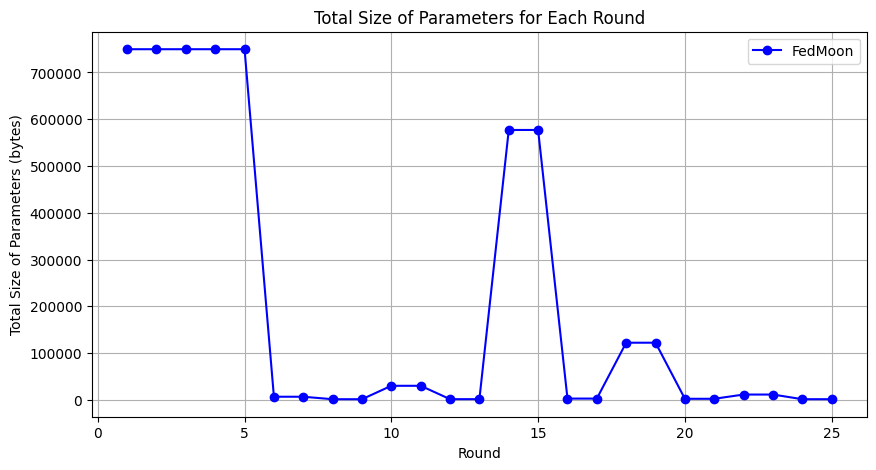

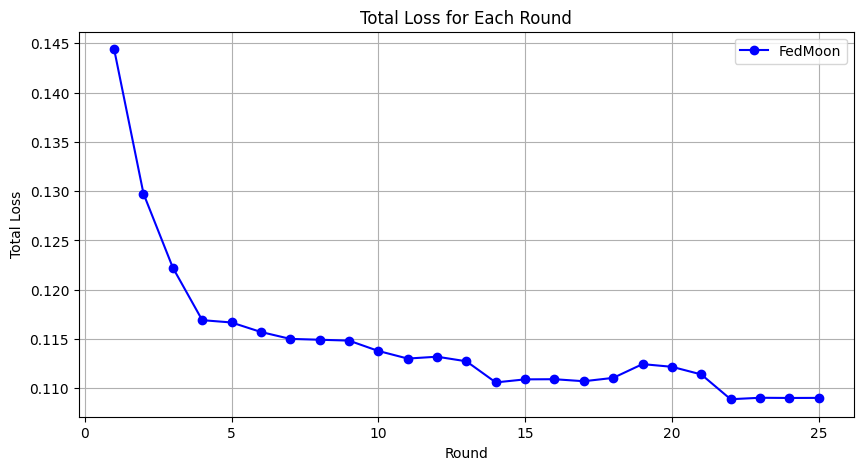

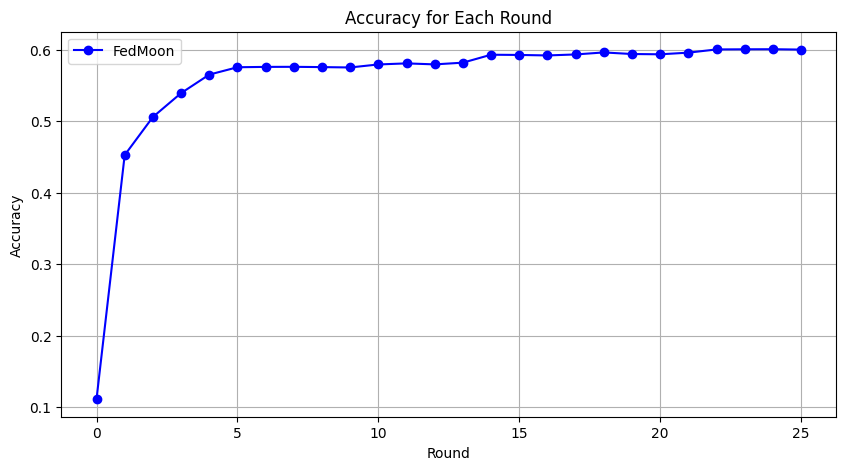

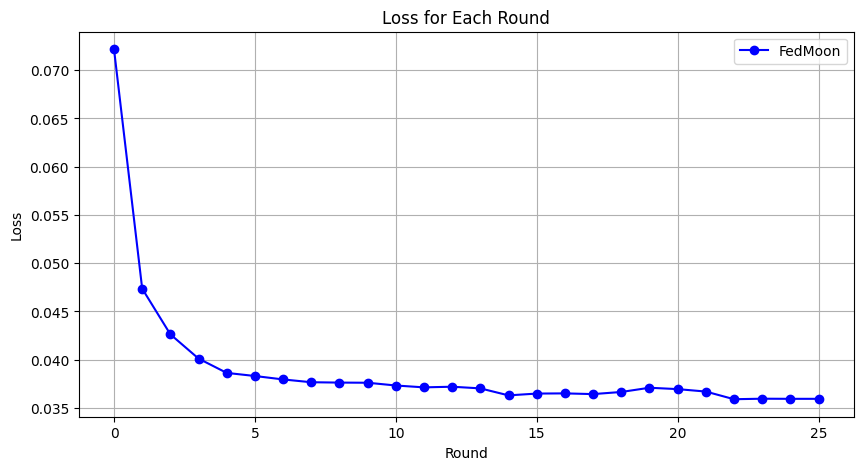

In [10]:
fed_moon_rounds = list(fed_moon_result.keys())
fed_moon_sizes = [fed_moon_result[round]["total_size"] for round in fed_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_moon_rounds, fed_moon_sizes, marker='o', linestyle='-', color='b', label='FedMoon')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_moon_losses = [fed_moon_result[round]["total_loss"] for round in fed_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_moon_rounds, fed_moon_losses, marker='o', linestyle='-', color='b', label='FedMoon')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)

fed_moon_model_rounds = list(fed_moon_model_results.keys())
fed_moon_accuracies = [fed_moon_model_results[round]["global_metrics"]["accuracy"] for round in fed_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_moon_model_rounds, fed_moon_accuracies, marker='o', linestyle='-', color='b', label='FedMoon')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_moon_global_losses = [fed_moon_model_results[round]["global_loss"] for round in fed_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_moon_model_rounds, fed_moon_global_losses, marker='o', linestyle='-', color='b', label='FedMoon')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.legend()
plt.grid(True)
